# Load dependencies

In [3]:
%load_ext autoreload
%autoreload 2

save_pdf=False
pp=[]

import os
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import pylab
import analyze_movements as am
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'font.family':'sans-serif'})
plt.rcParams.update({'font.sans-serif':'Arial'})
matplotlib.rcParams.update({'font.size': 10})
from matplotlib import cm
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib as mpl
from itertools import compress
import seaborn as sns
from scipy import signal,stats
from sklearn.linear_model import LinearRegression
from tqdm.notebook import trange, tqdm
import matplotlib.colors as mpc
import pylab
import cv2
from itertools import product, compress
import fnmatch
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, r'C:\Users\nlab\Desktop\GitHub Code\jumping_behavior')
import io_dict_to_hdf5 as ioh5
import util


### Set general plotting parameters
plt.rcParams.update({'font.size': 10})
plot_params = {'cm':pylab.get_cmap('jet'),
               'pointsize':3,
               'cond_col':['k',[0.6,0.6,0.6]],
               'hmm_col':[[0.6,0.6,0.6], 'k'],
               '4cond_col':[[1,0,0],'k',[0.5,0,0],[0.6,0.6,0.6]],
               'cond_sty':['-',':'],
               '4cond_sty':[':','-',':','-'],
               'plat_cols':['b','r','m'],
               'laser_col':['k','c'],
               'bm_col':['b','m']}

vid_dir = r'T:\jumping_revisions'
        
print('finished loading dependencies')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
finished loading dependencies


# Figure 1

In [2]:
# load data
pwin = 0.25 #half the movement duration window desired
# metric = 'position'
metric = 'velocity'
mvmnt_file = r'T:\jumping_revisions_analysis\variable_platform_mvmnts_%sms_%s.h5' % (int(pwin*1000),metric)
df_pickle = mvmnt_file[:-3] + '_df.h5'
labels_pickle = mvmnt_file[:-3] + '_labels.h5'
df_all = pd.read_hdf(df_pickle,key='df')
labels_all = pd.read_hdf(labels_pickle,key='df')

In [3]:
fig_dir = r'G:\My Drive\Niell\Jumping paper\Manuscript\Resubmission\Figures\Figure 1'

In [8]:
# load images from example trial
tr = 410
row = df_all.iloc[tr]
row

trial                                                                 7
success                                                               1
platform                                                              2
distance                                                             22
expdate                                                          013022
                                            ...                        
Side_nose_y_mvmnt     [[14.797618, 14.768506, 14.760393, 14.756081, ...
Side_mov_rel_jump     [-2.6607982394718417, -2.3807142142642794, -1....
Side_mov_rel_start    [0.03272727272727273, 0.13454545454545455, 0.3...
Side_windows                                      [9, 37, 84, 109, 113]
trial_length                                                        2.8
Name: 410, Length: 75, dtype: object

T:\jumping_revisions\013022\PVCHA7TT\013022_PVCHA7TT_control_6_SIDEcalibDLC_resnet50_jumping_revisionsFeb11shuffle1_1030000_filtered.h5
T:\jumping_revisions\013022\PVCHA7TT\013022_PVCHA7TT_control_TOP_6DLC_resnet50_jumping_revisionsFeb11shuffle1_1030000_filtered.h5


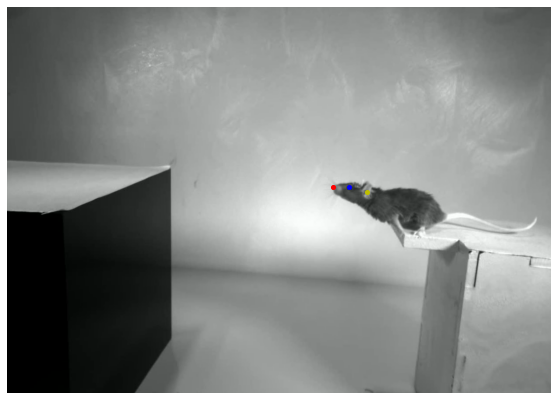

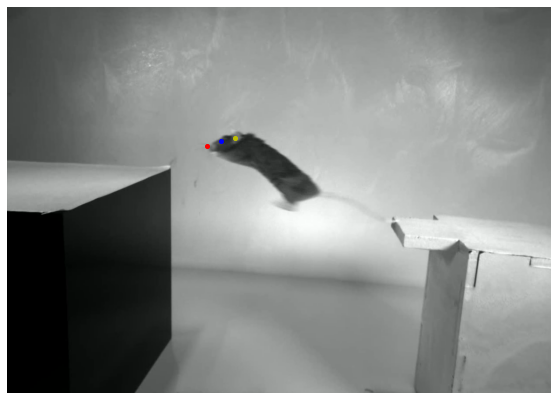

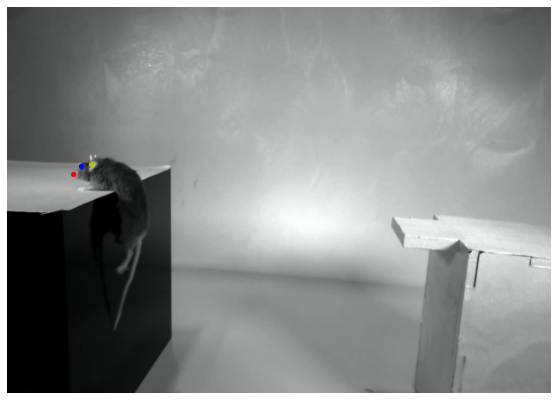

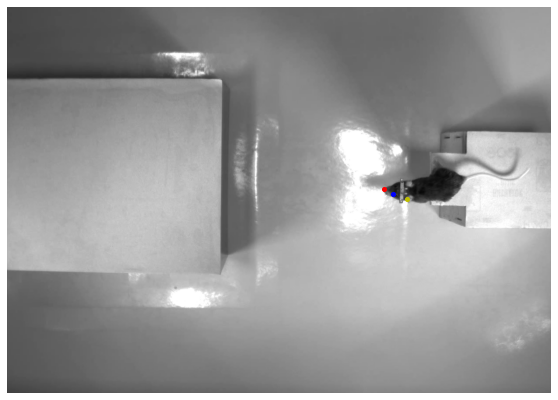

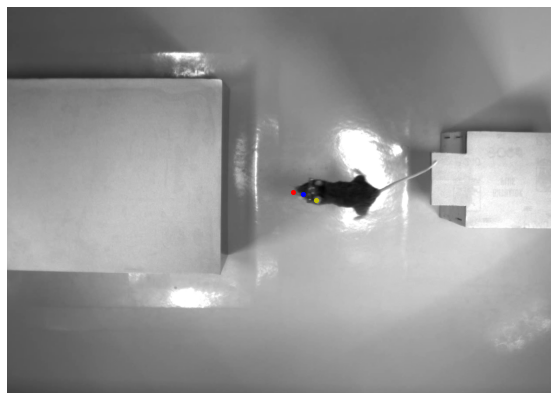

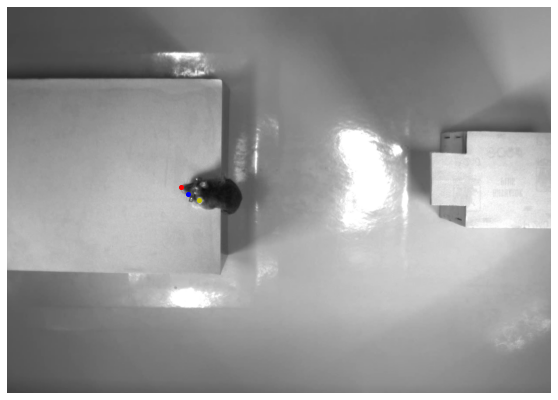

In [25]:


dlc_keys = ['Nose','LEye','LEar']
dlc_jump = np.zeros((len(dlc_keys),2))
dlc_mid = np.zeros((len(dlc_keys),2))
dlc_end = np.zeros((len(dlc_keys),2))

midoff = 1 #offset for middle frame selection
endoff = 2

for s,side in enumerate(['Side','Top']):
    vidname = am.vidname_from_row(vid_dir,side,row)
    jump,fps,frame_width,frame_height,ret = am.grab_vidframe(vidname,int(row[side + '_Jump']))
    mid,fps,frame_width,frame_height,ret = am.grab_vidframe(vidname,int(row[side + '_End']-(row[side + '_End']-row[side +'_Jump'])/2)+midoff)
    end,fps,frame_width,frame_height,ret = am.grab_vidframe(vidname,int(row[side + '_End'])+endoff)

    dlcname = am.dlc_file_from_row(vid_dir,side,row)
    print(dlcname)
    pts = pd.read_hdf(dlcname)
    pts.columns = [' '.join(col[:][1:3]).strip() for col in pts.columns.values]
    for k,key in enumerate(dlc_keys):
        dlc_jump[k,0] = pts[key + ' x'][int(row[side + '_Jump'])]
        dlc_jump[k,1] = pts[key + ' y'][int(row[side + '_Jump'])]
        dlc_mid[k,0] = pts[key + ' x'][int(row[side + '_End']-(row[side + '_End']-row[side +'_Jump'])/2)+midoff]
        dlc_mid[k,1] = pts[key + ' y'][int(row[side + '_End']-(row[side + '_End']-row[side +'_Jump'])/2)+midoff]
        dlc_end[k,0] = pts[key + ' x'][int(row[side + '_End'])+endoff]
        dlc_end[k,1] = pts[key + ' y'][int(row[side + '_End'])+endoff]


    crop = 100
    imshape = jump.shape
    cols = ['r','b','y']
    # jump = jump[crop:-crop,crop:-crop]
    # mid = mid[crop:-crop,crop:-crop]
    # end = end[crop:-crop,crop:-crop]
    
    fig_jump = plt.figure(figsize=(10,10*(jump.shape[0]-crop*2)/(jump.shape[1]-crop*2)))
    plt.imshow(jump)
    for i in range(len(dlc_keys)):
        plt.plot(dlc_jump[i,0],dlc_jump[i,1],'o',color=cols[i],markersize=4)
    plt.axis([crop,imshape[1]-crop,imshape[0]-crop,crop])
    plt.axis('off')
    fig_mid = plt.figure(figsize=(10,10*(jump.shape[0]-crop*2)/(jump.shape[1]-crop*2)))
    plt.imshow(mid)
    for i in range(len(dlc_keys)):
        plt.plot(dlc_mid[i,0],dlc_mid[i,1],'o',color=cols[i],markersize=4)
    plt.axis([crop,imshape[1]-crop,imshape[0]-crop,crop])
    plt.axis('off')
    fig_end = plt.figure(figsize=(10,10*(jump.shape[0]-crop*2)/(jump.shape[1]-crop*2)))
    plt.imshow(end)
    for i in range(len(dlc_keys)):
        plt.plot(dlc_end[i,0],dlc_end[i,1],'o',color=cols[i],markersize=4)
    plt.axis([crop,imshape[1]-crop,imshape[0]-crop,crop])
    plt.axis('off')

    fig_jump.savefig(os.path.join(fig_dir,'%s_jump.png' % side))
    fig_mid.savefig(os.path.join(fig_dir,'%s_mid.png' % side))
    fig_end.savefig(os.path.join(fig_dir,'%s_end.png' % side))

    # cv2.imwrite(os.path.join(fig_dir,'%s_jump.png' % side),jump)
    # cv2.imwrite(os.path.join(fig_dir,'%s_mid.png' % side),mid)
    # cv2.imwrite(os.path.join(fig_dir,'%s_end.png' % side),end)

# Figure 2

In [32]:
jump_file = r'T:\jumping_revisions_analysis\df_jumpDLCpoints_corrected.h5'
df_jump = pd.read_hdf(jump_file,key='df')

df_cond = df_jump[(df_jump['condition']=='control')|(df_jump['condition']=='suture')]
df_cond.reset_index(inplace=True,drop=True)
df_cond = df_cond[(df_cond['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)


(0.0, 1440.0, 830.0, 150.0)

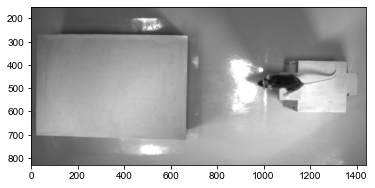

In [280]:
row = df_cond.iloc[0]
vidfile = am.vidname_from_row(vid_dir,'Top',row)
frame,fps,frame_width,frame_height,ret = am.grab_vidframe(vidfile,200)
plt.imshow(frame)
yoff=200
plt.axis([0,1440,1080-250,150])

In [367]:
# plot jumps
manipulation = 'ocular'
save_pdf = True
pdf_file = r'G:\My Drive\Niell\Jumping paper\Manuscript\Resubmission\Figures\Figure 2\jump_trajectories.pdf'
pp = PdfPages(pdf_file)
df_plot = df_cond[df_cond['success']==1]
am.plot_jumps(df_plot,vid_dir,'Top',save_pdf,pp,suptitle='')
pp.close()

In [20]:
pdf_file = r'G:\My Drive\Niell\Jumping paper\Manuscript\Resubmission\Figures\Figure 2\Figure_2_panels.pdf'
pp = PdfPages(pdf_file)
save_pdf = True

['binocular' 'monocular']
                                sum_sq    df         F    PR(>F)
C(distance_DLC)               0.178119   6.0  3.672752  0.002476
C(condition)                  0.000306   1.0  0.037897  0.846054
C(distance_DLC):C(condition)  0.008040   6.0  0.165775  0.985243
Residual                      0.792124  98.0       NaN       NaN

binocular success:                     sum_sq    df         F    PR(>F)
C(distance_DLC)  0.101417   6.0  2.316252  0.047755
Residual         0.357578  49.0       NaN       NaN
monocular success:                     sum_sq    df         F    PR(>F)
C(distance_DLC)  0.084741   6.0  1.592592  0.169349
Residual         0.434546  49.0       NaN       NaN
monocular
                                  sum_sq    df          F        PR(>F)
C(distance_DLC)               456.582907   6.0  16.971588  2.368106e-13
C(condition)                    5.382497   1.0   1.200433  2.759205e-01
C(distance_DLC):C(condition)    8.293921   6.0   0.308292  9.312918e-0

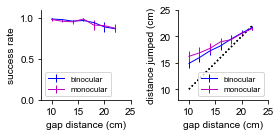

In [19]:
#plot bi/mono success and distance jumped
fig, axs = plt.subplots(1,2,figsize=(4,2))
ax = axs[0]
ax, anova_df = am.plot_performance(ax=ax,og_df=df_cond,condition='ocular',aborts=True,plt_min=8,plt_max=24,color_scheme=plot_params['bm_col'])

temp_df = anova_df[anova_df['condition']=='binocular']
model = ols('success ~ C(distance_DLC)', data=temp_df).fit()
print('binocular success: ', sm.stats.anova_lm(model, typ=2))

temp_df = anova_df[anova_df['condition']=='monocular']
model = ols('success ~ C(distance_DLC)', data=temp_df).fit()
print('monocular success: ', sm.stats.anova_lm(model, typ=2))

ax = axs[1]
ax, anova_df = am.plot_jumpdist(ax=ax,og_df=df_cond,condition='ocular',plt_min=8,plt_max=24,color_scheme=plot_params['bm_col'])

temp_df = anova_df[anova_df['condition']=='binocular']
model = ols('jumpdist ~ C(distance_DLC)', data=temp_df).fit()
print('binocular jumpdist: ', sm.stats.anova_lm(model, typ=2))

temp_df = anova_df[anova_df['condition']=='monocular']
model = ols('jumpdist ~ C(distance_DLC)', data=temp_df).fit()
print('monocular jumpdist: ', sm.stats.anova_lm(model, typ=2))

fig.tight_layout()

if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

t-test p=0.21


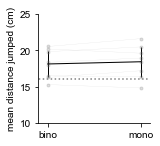

In [22]:
ocs = np.unique(df_cond['ocular'])
anis = np.unique(df_cond['subject'])

d_jumpdist = np.zeros((len(anis),len(ocs)))
for o,oc in enumerate(ocs):
    df = df_cond[(df_cond['ocular']==oc)&(df_cond['success']==1)]
    jumpcurve = df.groupby(['subject']).median()
    d_jumpdist[:,o] = jumpcurve['jumpdist'].to_numpy()

fig, axs = plt.subplots(1,1,figsize=(2,2))
for a,ani in enumerate(anis):
    axs.plot([1,2],[d_jumpdist[a,0],d_jumpdist[a,1]],'.-',linewidth=0.25,alpha=0.25,color=[0.5,0.5,0.5])
axs.errorbar(x=[1,2],y=[np.mean(d_jumpdist[:,0]),np.mean(d_jumpdist[:,1])],yerr=[np.std(d_jumpdist[:,0]),np.std(d_jumpdist[:,1])],color='k',linewidth=1)
axs.plot([0,2.5],[np.mean([10,22]),np.mean([10,22])],':',color=[0.5,0.5,0.5])
axs.set_ylim(10,25)
axs.set_xlim(0.9,2.1)
axs.set_ylabel('mean distance jumped (cm)')
axs.set_xticks([1,2])
axs.set_xticklabels(['bino','mono'])
axs = am.xy_axis(axs)

s,p = stats.ttest_rel(d_jumpdist[:,0],d_jumpdist[:,1])
print('t-test p=%0.2f' % p)



### performance by platform width

binocular
                                   sum_sq     df         F    PR(>F)
C(distance_DLC)                  0.248298    6.0  4.895432  0.000137
C(platform_DLC)                  0.039638    2.0  2.344526  0.099469
C(distance_DLC):C(platform_DLC)  0.045287   12.0  0.446440  0.941687
Residual                         1.242649  147.0       NaN       NaN

monocular
                                   sum_sq     df         F    PR(>F)
C(distance_DLC)                  0.304739    6.0  2.519627  0.023789
C(platform_DLC)                  0.031205    2.0  0.774029  0.463034
C(distance_DLC):C(platform_DLC)  0.162146   12.0  0.670325  0.777662
Residual                         2.943016  146.0       NaN       NaN



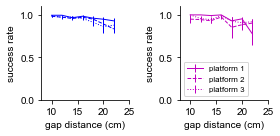

In [20]:
ls_list = ['-','--',':']
fig, axs = plt.subplots(1,2,figsize=(4,2))
am.plot_performance_platforms(axs=axs,og_df=df_cond,condition='ocular',aborts=True,plt_min=8,plt_max=24,color_scheme=plot_params['bm_col'],ls_list=ls_list)
fig.tight_layout()

if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

binocular
                                     sum_sq     df          F        PR(>F)
C(distance_DLC)                  871.758123    6.0  35.052851  4.418057e-26
C(platform_DLC)                   36.777264    2.0   4.436373  1.346528e-02
C(distance_DLC):C(platform_DLC)    5.813125   12.0   0.116871  9.998940e-01
Residual                         609.310602  147.0        NaN           NaN

monocular
                                     sum_sq     df          F        PR(>F)
C(distance_DLC)                  527.364646    6.0  14.761869  4.191802e-13
C(platform_DLC)                   38.827087    2.0   3.260517  4.121941e-02
C(distance_DLC):C(platform_DLC)    8.649049   12.0   0.121051  9.998717e-01
Residual                         857.394893  144.0        NaN           NaN



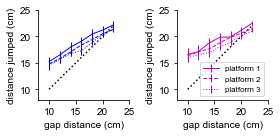

In [27]:
fig, axs = plt.subplots(1,2,figsize=(4,2))
axs = am.plot_jumpdist_platforms(axs=axs,og_df=df_cond,condition='ocular',plt_min=8,plt_max=24,color_scheme=plot_params['bm_col'],ls_list=ls_list)
fig.tight_layout()

if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

In [35]:
df_cond[df_cond['condition']=='suture'].shape

(1613, 57)

### changes in landing position mean/variance

In [3]:
save_pdf=False
pp=[]

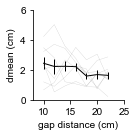

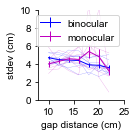

In [4]:
jump_file = r'T:\jumping_revisions_analysis\df_jumpDLCpoints_corrected.h5'
df_jump = pd.read_hdf(jump_file,key='df')

df_cond = df_jump[(df_jump['condition']=='control')|(df_jump['condition']=='suture')]
df_cond.reset_index(inplace=True,drop=True)
df_cond = df_cond[(df_cond['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)

dists = np.unique(df_cond['distance_DLC'])
anis = np.unique(df_cond['subject'])
ocular = np.unique(df_cond['ocular'])

mn_land_diff = np.zeros((len(dists),len(anis)))
mn_x_diff = np.zeros((len(dists),len(anis)))
mn_y_diff = np.zeros((len(dists),len(anis)))
std_land_diff = np.zeros((len(dists),len(ocular),len(anis)))
std_x_diff = np.zeros((len(dists),len(ocular),len(anis)))
std_y_diff = np.zeros((len(dists),len(ocular),len(anis)))

for a,ani in enumerate(anis):
    df_ani = df_cond[(df_cond['subject']==ani)&(df_cond['success']==1)]
    df_ani.reset_index(inplace=True,drop=True)

    for d,dist in enumerate(dists):
        mn_land = np.zeros(4) #x1,x2,y1,y2
        for o,oc in enumerate(ocular):
            temp_df = df_ani[(df_ani['distance_DLC']==dist)&(df_ani['ocular']==oc)]
            temp_df.reset_index(inplace=True,drop=True)

            #get landing positions
            xs = np.array([i[-1] for i in temp_df['Top LEar x']])/df_ani['Top_pixpercm'].iloc[0]
            ys = np.array([i[-1] for i in temp_df['Top LEar y']])/df_ani['Top_pixpercm'].iloc[0]
    
            mn_land[o] = np.nanmean(xs)
            mn_land[o+2] = np.nanmean(ys)
            
            std_land_diff[d,o,a] = np.std(xs) + np.std(ys)
            std_x_diff[d,o,a] = np.std(xs)
            std_y_diff[d,o,a] = np.std(ys)

        mn_land_diff[d,a] = np.sqrt((mn_land[1]-mn_land[0])**2 + (mn_land[3]-mn_land[2])**2)
        mn_x_diff[d,a] = np.abs(mn_land[1]-mn_land[0])
        mn_y_diff[d,a] = np.abs(mn_land[3]-mn_land[2])


fig, ax = plt.subplots(1,1,figsize=(2,2))
ax.errorbar(x=dists,y=np.nanmean(mn_land_diff,axis=1),yerr=np.nanstd(mn_land_diff,axis=1)/np.sqrt(len(anis)),color='k',linewidth=1,zorder=0)
#add individual animal plots?
for a,ani in enumerate(anis):
    ax.plot(dists,mn_land_diff[:,a],color=[0.5,0.5,0.5],linewidth=0.25,alpha=0.5)
ax.set_xlim(8,24)
ax.set_xticks(np.arange(10,30,5))
ax.set_ylim(0,6)
ax.set_yticks(np.arange(0,8,2))
ax.set_xlabel('gap distance (cm)')
ax.set_ylabel('dmean (cm)')
ax = am.xy_axis(ax)
# plt.suptitle('binocular vs. monocular')
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

fig, ax = plt.subplots(1,1,figsize=(2,2))
for o,oc in enumerate(ocular):
    ax.errorbar(x=dists,y=np.nanmean(std_land_diff[:,o,:],axis=1),yerr=np.nanstd(std_land_diff[:,o,:],axis=1)/np.sqrt(len(anis)),color=plot_params['bm_col'][o],label=oc,linewidth=1,zorder=o)
#add individual animal plots?
for a,ani in enumerate(anis):
    for o,oc in enumerate(ocular):
        ax.plot(dists,std_land_diff[:,o,a],color=plot_params['bm_col'][o],linewidth=0.25,alpha=0.5)

ax.set_xlim(8,24)
ax.set_xticks(np.arange(10,30,5))
ax.set_ylim(0,10)
ax.set_yticks(np.arange(0,12,2))
ax.set_xlabel('gap distance (cm)')
ax.set_ylabel('stdev (cm)')
ax = am.xy_axis(ax)
ax.legend()
# plt.suptitle('binocular vs. monocular')
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

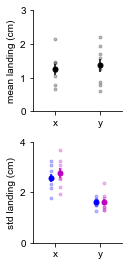

In [5]:
fig, axs = plt.subplots(2,1,figsize=(1.9,3.8))
axs = axs.ravel()

numAni = len(np.unique(df_cond['subject']))

ax = axs[0] # mean change in x/y
ax.plot([np.ones(numAni),np.ones(numAni)*2],[np.nanmean(mn_x_diff,axis=0),np.nanmean(mn_y_diff,axis=0)],'ko',markersize=3,alpha=0.25)
ax.errorbar(x=[1,2],y=[np.nanmean(np.nanmean(mn_x_diff,axis=0)),np.nanmean(np.nanmean(mn_y_diff,axis=0))],\
    yerr=[np.nanstd(np.nanmean(mn_x_diff,axis=0))/np.sqrt(numAni),np.nanstd(np.nanmean(mn_y_diff,axis=0))/np.sqrt(numAni)],ls='none',marker='o',color='k',markersize=5)
ax.axis([0.5,2.5,0,3])
ax.set_xticks([1,2])
ax.set_xticklabels(['x','y'])
ax.set_yticks([0,1,2,3])
ax.set_ylabel('mean landing (cm)')
ax = am.xy_axis(ax)

ax = axs[1] # mean change in x/y
ax.plot([np.ones(numAni)*0.9,np.ones(numAni)*1.9],[np.nanmean(std_x_diff[:,0,:],axis=0),np.nanmean(std_y_diff[:,0,:],axis=0)],'bo',markersize=3,alpha=0.25)
ax.errorbar(x=[0.9,1.9],y=[np.nanmean(np.nanmean(std_x_diff[:,0,:],axis=0)),np.nanmean(np.nanmean(std_y_diff[:,0,:],axis=0))],\
    yerr=[np.nanstd(np.nanmean(std_x_diff[:,0,:],axis=0))/np.sqrt(numAni),np.nanstd(np.nanmean(std_y_diff[:,0,:],axis=0))/np.sqrt(numAni)],ls='none',marker='o',color='b',markersize=5)
ax.plot([np.ones(numAni)*1.1,np.ones(numAni)*2.1],[np.nanmean(std_x_diff[:,1,:],axis=0),np.nanmean(std_y_diff[:,1,:],axis=0)],'mo',markersize=3,alpha=0.25)
ax.errorbar(x=[1.1,2.1],y=[np.nanmean(np.nanmean(std_x_diff[:,1,:],axis=0)),np.nanmean(np.nanmean(std_y_diff[:,1,:],axis=0))],\
    yerr=[np.nanstd(np.nanmean(std_x_diff[:,1,:],axis=0))/np.sqrt(numAni),np.nanstd(np.nanmean(std_y_diff[:,1,:],axis=0))/np.sqrt(numAni)],ls='none',marker='o',color='m',markersize=5)

ax.set_xticks([1,2])
ax.set_xticklabels(['x','y'])
ax.axis([0.5,2.5,0,4])
ax.set_yticks([0,2,4])
ax.set_ylabel('std landing (cm)')
ax = am.xy_axis(ax)

fig.tight_layout()
if save_pdf:
    pp.savefig(fig)

In [7]:
stats.ttest_1samp(np.mean(mn_x_diff,axis=0),0)

Ttest_1sampResult(statistic=7.5867082214373145, pvalue=0.00012768759399710763)

In [27]:
#close the pdf
pp.close()

# Figure 3

### plot example movements and clusters

In [199]:
pwin = 0.25 #half the movement duration window desired
# metric = 'position'
metric = 'velocity'
mvmnt_file = r'T:\jumping_revisions_analysis\hclusters_revision_mvmnts_1cmY_250ms_velocity.h5' #% (int(pwin*1000),metric)
df_pickle = mvmnt_file[:-3] + '_df.h5'
labels_pickle = mvmnt_file[:-3] + '_labels.h5'
df_all = pd.read_hdf(df_pickle,key='df')
labels_all = pd.read_hdf(labels_pickle,key='df')

base_df = df_all.copy()
base_df = base_df[(base_df['condition']=='control')|(base_df['condition']=='suture')]
base_df.reset_index(inplace=True,drop=True)
base_df = am.remove_aborts(base_df)
base_labels = labels_all.copy()
base_labels = base_labels[(base_labels['condition']=='control')|(base_labels['condition']=='suture')]
base_labels.reset_index(inplace=True,drop=True)
base_labels = am.remove_aborts(base_labels)

In [89]:
labels_all.shape

(40868, 31)

In [168]:
save_pdf = True
pdf_file = r'G:\My Drive\Niell\Jumping paper\Manuscript\Resubmission\Figures\Figure 3\Figure_3_panels.pdf'
pp = PdfPages(pdf_file)

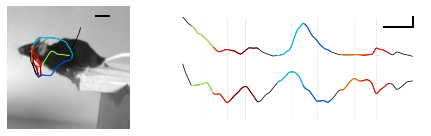

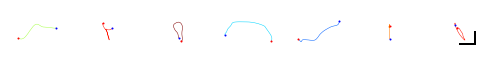

In [207]:
save_pdf = False
# pp=[]
# rn = np.where((base_df['subject']=='PVCHA6LN')&(base_df['expdate']=='020222')&(base_df['trial']==32))[0][0]
rn = np.where((base_df['subject']=='PVCHA6RT')&(base_df['expdate']=='020622')&(base_df['trial']==16))[0][0] #nice big bob
# rn = np.where((base_df['subject']=='PVCHA6RT')&(base_df['expdate']=='020622')&(base_df['trial']==16))[0][0]
# rn = np.where((base_df['subject']=='PVCHA7LT')&(base_df['expdate']=='021922')&(base_df['trial']==16))[0][0]
# rn = 2100
row = base_df.iloc[rn]

key = 'LEye'
plim=6
like_thresh=0.99
vid_dir = r'T:\jumping_revisions'
side = 'Side'

am.plot_example_trial_movements(row,base_labels,key,'kmeans',pwin,plim,like_thresh,vid_dir,side,save_pdf,pp)


In [255]:
df_row = row
labels = base_labels.copy()
cluster_key = 'kmeans'
base_path = r'G:\My Drive\Niell\Jumping paper\Manuscript\Resubmission\Videos'
vid_path = vid_dir
side = 'Side'
pwin=0.25
tdown = 3
sdown = 1

am.make_bob_vids_trial(df,labels,idx,cluster_key,base_path,vid_path,side,tdown,sdown)

created 020622_PVCHA6RT_control_15_SIDEcalib.avi


(array([409., 137.,  32.,  30.,  15.,  14.,  10.,   8.,   6.,  10.]),
 array([9.7245602e-03, 1.7253466e+00, 3.4409688e+00, 5.1565909e+00,
        6.8722129e+00, 8.5878344e+00, 1.0303457e+01, 1.2019079e+01,
        1.3734701e+01, 1.5450323e+01, 1.7165945e+01], dtype=float32),
 <BarContainer object of 10 artists>)

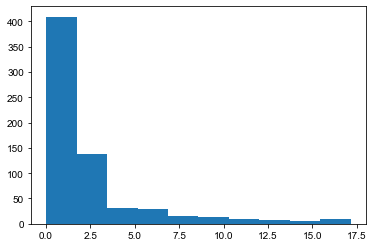

In [619]:
vel_trace = np.abs(np.diff(row['Side LEye x'][2:-2]/row['Side_pixpercm']))*row['fps']
plt.hist(vel_trace)

In [623]:
immobile_time = []
for index,row in df_cond.iterrows():
    vel_trace = np.abs(np.diff(row['Side LEye x'][2:-2]/row['Side_pixpercm']))*row['fps']
    immobile_time.append(np.sum(vel_trace<0.25)/row['fps'])
df_cond['immobile_time'] = immobile_time

binocular 0.37+/-0.04, monocular 1.08+/-0.41, ocular immobile_time t-test p=0.152


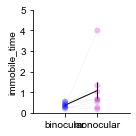

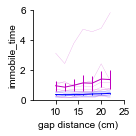

In [643]:
fig, ax, p = am.plot_variable_condition(df_cond,'ocular','immobile_time',0,3,0,5,plot_params['bm_col'],save_pdf,pp)

fig, ax = plt.subplots(1,1,figsize=(2,2))
ax = am.plot_variable_vs_distance(ax,df_cond,'immobile_time','ocular',5,25,0,6,plot_params['bm_col'],save_pdf,pp,suptitle='')
fig.tight_layout()

499 -0.008613010276022763


-0.008613010276022763

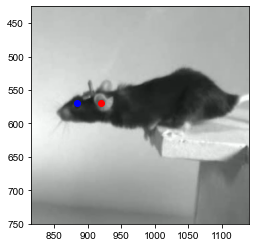

In [142]:
rn = 1000
row = df_corrected_pitch.iloc[rn]
fr = np.nanargmin(np.abs(df_corrected_pitch['Side_pitch'][rn]))
print(fr,df_corrected_pitch['Side_pitch'][rn][fr])
vidname = am.vidname_from_row(vid_dir,'Side',row)
frame,fps,frame_width,frame_height,ret = am.grab_vidframe(vidname,fr+int(row['Side_Start']))
eye_x,eye_y,ear_x,ear_y = am.eye_ear_from_row(row,vid_dir,0.95)
plt.imshow(frame)
plt.axis([815,1140,750,425])
# eye_x = row['Side LEye x']
# eye_y = row['Side LEye y']
# ear_x = row['Side LEar x']
# ear_y = row['Side LEar y']
plt.plot(eye_x[fr],eye_y[fr],'bo')
plt.plot(ear_x[fr],ear_y[fr],'ro')
np.degrees(np.arctan2(ear_y[fr]-eye_y[fr],ear_x[fr]-eye_x[fr]))

887 21.509903082223037


21.509903082223037

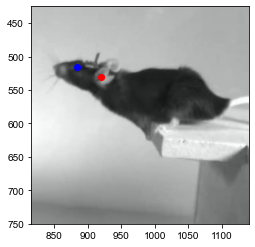

In [143]:
rn = 1000
row = df_corrected_pitch.iloc[rn]
fr = np.nanargmin(np.abs(df_corrected_pitch['Side_pitch'][rn]-30))
print(fr,df_corrected_pitch['Side_pitch'][rn][fr])
vidname = am.vidname_from_row(vid_dir,'Side',row)
frame,fps,frame_width,frame_height,ret = am.grab_vidframe(vidname,fr+int(row['Side_Start']))
eye_x,eye_y,ear_x,ear_y = am.eye_ear_from_row(row,vid_dir,0.95)
plt.imshow(frame)
plt.axis([815,1140,750,425])
# eye_x = row['Side LEye x']
# eye_y = row['Side LEye y']
# ear_x = row['Side LEar x']
# ear_y = row['Side LEar y']
plt.plot(eye_x[fr],eye_y[fr],'bo')
plt.plot(ear_x[fr],ear_y[fr],'ro')
np.degrees(np.arctan2(ear_y[fr]-eye_y[fr],ear_x[fr]-eye_x[fr]))

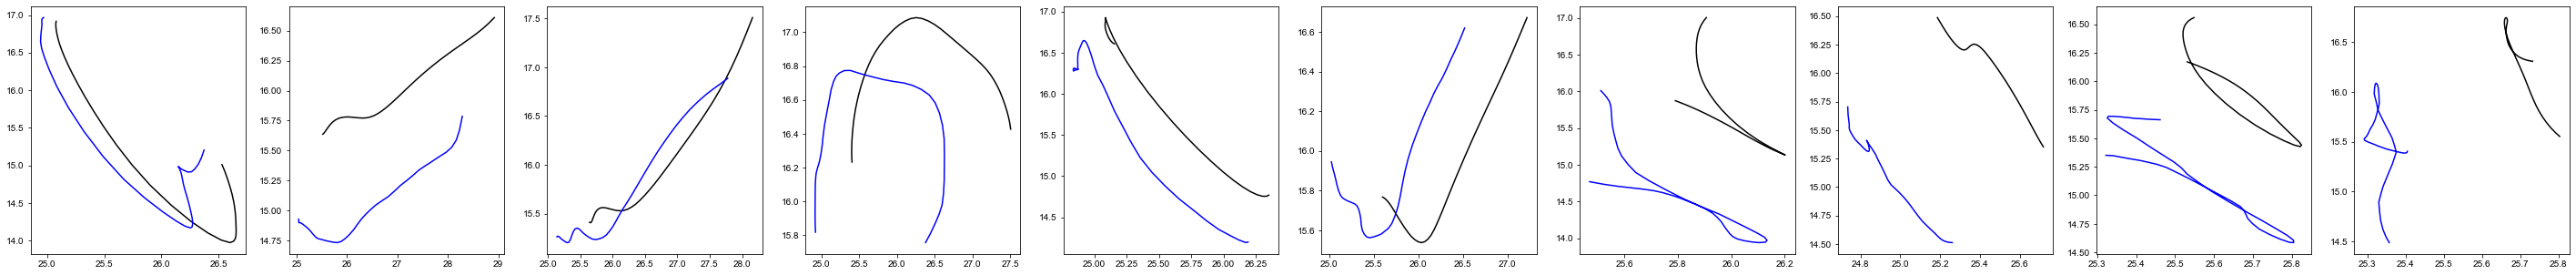

In [170]:
cluster_key = 'kmeans'
side = 'Side'

n_k = len(np.unique(base_labels[cluster_key]))
cc_to_mean = np.zeros((len(base_labels),n_k))
best_ind = np.zeros(n_k).astype(int)

fig, axs = plt.subplots(1,n_k,figsize=(5*n_k,5))
axs = axs.ravel()

for K in range(n_k):
    ax = axs[K]
    idxs = np.where(base_labels[cluster_key]==K)[0]

    x = base_labels['Side_x_eye_mvmnt'][idxs].mean()
    y = base_labels['Side_y_eye_mvmnt'][idxs].mean()
    ax.plot(x,y,'k')

    cc = np.array([np.corrcoef(np.hstack([x,y]),np.hstack([tx,ty]))[0,1] for tx,ty in zip(base_labels['Side_x_eye_mvmnt'],base_labels['Side_y_eye_mvmnt'])])
    cc_to_mean[:,K] = cc
    best_ind[K] = np.argmax(cc_to_mean[:,K])
    # if K==0:
    #     bad_ind = np.argmax(cc_to_mean[:,K])
    #     cc_to_mean[bad_ind,K] = 0
    #     best_ind[K] = np.argmax(cc_to_mean[:,K])
    # if K==5:
    #     bad_ind = np.argmax(cc_to_mean[:,K])
    #     cc_to_mean[bad_ind,K] = 0
    #     bad_ind = np.argmax(cc_to_mean[:,K])
    #     cc_to_mean[bad_ind,K] = 0
    #     best_ind[K] = np.argmax(cc_to_mean[:,K])
    # elif K==9:
    #     bad_ind = np.argmax(cc_to_mean[:,K])
    #     cc_to_mean[bad_ind,K] = 0
    #     bad_ind = np.argmax(cc_to_mean[:,K])
    #     cc_to_mean[bad_ind,K] = 0
    #     best_ind[K] = np.argmax(cc_to_mean[:,K])

    x = base_labels['Side_x_eye_mvmnt'][best_ind[K]]
    y = base_labels['Side_y_eye_mvmnt'][best_ind[K]]
    ax.plot(x,y,'b')

    


In [171]:
fig, axs = plt.subplots(1,n_k,figsize=(8,2))
axs = axs.ravel()

for b,best in enumerate(best_ind):
    ax = axs[b]
    row = base_labels.iloc[int(best)]
    vid_file = am.vidname_from_row(vid_dir,side,row)
    df_row = am.df_row_from_labels(base_df,row)
    frame,fps,frame_width,frame_height,ret = am.grab_vidframe(vid_file,int(row['Side_windows'])+int(df_row['Side_Start']))
    ax.imshow(frame)

    dlc_file = am.dlc_file_from_row(vid_dir,side,row)
    pts = pd.read_hdf(dlc_file)
    pts.columns = [' '.join(col[:][1:3]).strip() for col in pts.columns.values]
    eye_x = pts['LEye x'][int(df_row['Side_Start']+row['Side_windows']):int(df_row['Side_Start']+row['Side_windows']+pwin*2*df_row['fps'])].to_numpy()
    eye_y = pts['LEye y'][int(df_row['Side_Start']+row['Side_windows']):int(df_row['Side_Start']+row['Side_windows']+pwin*2*df_row['fps'])].to_numpy()

    ax.plot(eye_x,eye_y,'m',linewidth=1,label='movement')
    ax.plot(eye_x[0],eye_y[0],'bo',markersize=2,label='start')
    ax.plot(eye_x[-1],eye_y[-1],'ro',markersize=2,label='end')
    ax.axis([815,1140,750,425])
    # ax.set_title('cluster %d' % (b+1))
    ax.axis('off')
# ax.legend(loc=3)
fig.tight_layout()
if save_pdf:
    pp.savefig(fig,dpi=300)
    plt.close(fig)



condition = 'ocular'
fig, ax = am.plot_movement_clusters(base_df,base_labels,side,cluster_key,condition,plot_params,save_pdf,pp)



### plot movement fequencies, trial durations

In [172]:
# save_pdf = False
# pp=[]

cluster_key='kmeans'
condition='ocular'
side='Side'
fig, ax = am.plot_movement_clusters(base_df,base_labels,side,cluster_key,condition,plot_params,save_pdf,pp)

fig, axs = plt.subplots(1,1,figsize=(2,2))
axs, freq = am.plot_cluster_freq(axs,base_df,base_labels,cluster_key,condition,0,2,plot_params['bm_col'],save_pdf,pp)
# axs.legend(['binocular','monocular'],loc=2)
axs.set_yticks(np.arange(0,3,1))
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)
print('alpha = %0.3f' % (0.05/len(np.unique(base_labels[cluster_key]))))

cluster 1 p=0.461
cluster 2 p=0.039
cluster 3 p=0.148
cluster 4 p=0.195
cluster 5 p=0.148
cluster 6 p=0.312
cluster 7 p=0.109
cluster 8 p=0.312
cluster 9 p=0.109
cluster 10 p=0.312
alpha = 0.005


In [173]:
n_clust = freq.shape[2]
num_ani = freq.shape[1]
anova_df = pd.DataFrame(columns=['cluster','condition','frequency'])

for clust in range(n_clust):
    temp_df = pd.DataFrame(columns=['cluster','condition','frequency'])
    temp_df['cluster'] = np.ones(num_ani*2)*clust
    temp_df['condition'] = np.hstack((np.zeros(num_ani),np.ones(num_ani))).astype(int)
    temp_df['frequency'] = np.hstack((freq[0,:,clust],freq[1,:,clust]))

    anova_df = pd.concat([anova_df,temp_df])

model = ols('frequency ~ C(cluster) + C(condition) + C(cluster):C(condition)', data=anova_df).fit()
print('anova frequency as a function of cluster and condition')
print(sm.stats.anova_lm(model, typ=2))

anova frequency as a function of cluster and condition
                            sum_sq     df          F        PR(>F)
C(cluster)               16.948337    9.0  19.442076  8.187697e-21
C(condition)              1.611026    1.0  16.632621  7.577116e-05
C(cluster):C(condition)   0.744881    9.0   0.854481  5.675416e-01
Residual                 13.560322  140.0        NaN           NaN


In [332]:
# pdf_file = r'T:\jumping_revisions_analysis\ani_motif_freq.pdf'
# pp = PdfPages(pdf_file)

# anis = np.unique(base_df['subject'])
# for n in range(freq.shape[1]):
#     fig = plt.figure(figsize=(5,5))
#     plt.plot(np.arange(1,11,1),freq[0,n,:],'bo')
#     plt.plot(np.arange(1,11,1),freq[1,n,:],'mo')
#     plt.axis([0,11,0,4])
#     plt.title(anis[n])
#     pp.savefig(fig)
#     plt.close(fig)
# pp.close()

(0.44087920358952876, 0.27422467793792565)

0.5042353675970108 [[-8.2657568]]


(-0.7100953228947582, 0.04843620851747452)

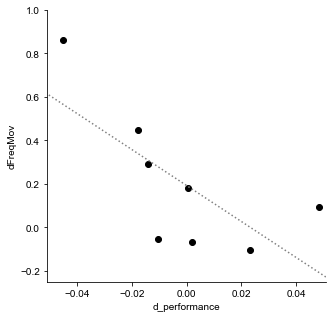

In [536]:
success = np.zeros(len(anis))
for a,ani in enumerate(anis):
    success[a] = len(df_cond[(df_cond['subject']==ani)&(df_cond['condition']=='suture')&(df_cond['success']==1)])/len(df_cond[(df_cond['subject']==ani)&(df_cond['condition']=='suture')])-\
        len(df_cond[(df_cond['subject']==ani)&(df_cond['condition']=='control')&(df_cond['success']==1)])/len(df_cond[(df_cond['subject']==ani)&(df_cond['condition']=='control')])

reg = LinearRegression().fit(success.reshape(-1,1),d_mov.reshape(-1,1))
print(reg.score(success.reshape(-1,1),d_mov.reshape(-1,1)),reg.coef_)

fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.scatter(success,d_mov,color='k')
axs.plot(np.arange(-1,1.1,0.1),reg.predict(np.arange(-1,1.1,0.1).reshape(-1,1)),':',color=[0.5,0.5,0.5])
axs.axis([-0.051,0.051,-0.25,1])
axs.set_xlabel('d_performance')
axs.set_ylabel('dFreqMov')
axs = am.xy_axis(axs)

stats.pearsonr(success,d_mov)

0.014575607502710697 [[0.34365895]]


(0.1207294806694326, 0.7758222373587278)

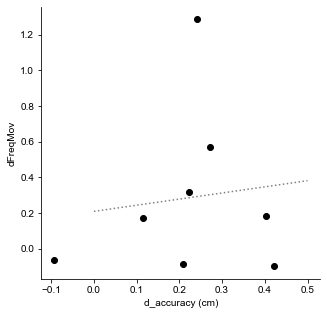

In [143]:
d_accuracy = np.zeros(len(anis))
for a,ani in enumerate(anis):
    d_accuracy[a] = np.nanmean(df_cond[(df_cond['subject']==ani)&(df_cond['condition']=='suture')&(df_cond['success']==1)]['accuracy'].to_numpy())-\
        np.nanmean(df_cond[(df_cond['subject']==ani)&(df_cond['condition']=='control')&(df_cond['success']==1)]['accuracy'].to_numpy())

reg = LinearRegression().fit(d_accuracy.reshape(-1,1),d_mov.reshape(-1,1))
print(reg.score(d_accuracy.reshape(-1,1),d_mov.reshape(-1,1)),reg.coef_)

fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.scatter(d_accuracy,d_mov,color='k')
axs.plot(np.arange(0,0.6,0.1),reg.predict(np.arange(0,0.6,0.1).reshape(-1,1)),':',color=[0.5,0.5,0.5])
# axs.axis([0,0.5,-0.25,1])
axs.set_xlabel('d_accuracy (cm)')
axs.set_ylabel('dFreqMov')
axs = am.xy_axis(axs)

stats.pearsonr(d_accuracy,d_mov)

0.21090862819109313 [[-15.51130484]]


(-0.4592478940518871, 0.25232370110909225)

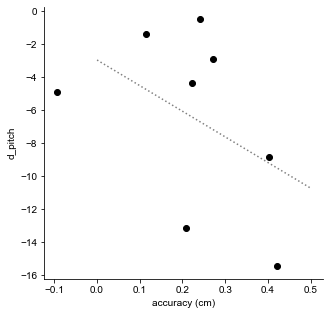

In [572]:
reg = LinearRegression().fit(accuracy.reshape(-1,1),d_pitch.reshape(-1,1))
print(reg.score(accuracy.reshape(-1,1),d_pitch.reshape(-1,1)),reg.coef_)

fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.scatter(accuracy,d_pitch,color='k')
axs.plot(np.arange(0,0.6,0.1),reg.predict(np.arange(0,0.6,0.1).reshape(-1,1)),':',color=[0.5,0.5,0.5])
# axs.axis([0,0.5,-20,20])
axs.set_xlabel('accuracy (cm)')
axs.set_ylabel('d_pitch')
axs = am.xy_axis(axs)

stats.pearsonr(accuracy,d_pitch)

In [174]:
mvmnt_integral = []
trial_duration = []
for index,row in base_df.iterrows():
    x_int = np.sum(np.abs(np.diff(row['Side LEye x'][2:-2]/row['Side_pixpercm'])))
    y_int = np.sum(np.abs(np.diff(row['Side LEye y'][2:-2]/row['Side_pixpercm'])))
    tr_dur = len(row['Side LEye x'][2:-2])/row['fps']
    mvmnt_integral.append(x_int+y_int)
    trial_duration.append(tr_dur)
base_df['mvmnt_integral'] = mvmnt_integral
base_df['trial_duration'] = trial_duration


condition = 'ocular'
variable = 'mvmnt_integral'
fig, axs, p, d_var = am.plot_variable_condition(base_df,condition,variable,0.9,2.1,0,60,plot_params['bm_col'],save_pdf,pp)
# axs.set_title('total movement distance')

variable = 'trial_duration'
fig, axs, p, d_var = am.plot_variable_condition(base_df,condition,variable,0.9,2.1,0,15,plot_params['bm_col'],save_pdf,pp)

binocular 14.65+/-1.27, monocular 28.73+/-5.01, ocular mvmnt_integral t-test p=0.036
binocular 2.48+/-0.27, monocular 5.56+/-1.31, ocular trial_duration t-test p=0.061


binocular 6.19+/-0.33, monocular 5.67+/-0.34, ocular mvmnt_integral t-test p=0.043


Text(0.5, 1.0, 'movement distance/s')

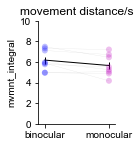

In [518]:
mvmnt_integral = []
for index,row in df_cond.iterrows():
    x_int = np.sum(np.abs(np.diff(row['Side LEye x'][2:-2]/row['Side_pixpercm'])))
    y_int = np.sum(np.abs(np.diff(row['Side LEye y'][2:-2]/row['Side_pixpercm'])))
    tr_dur = len(row['Side LEye x'][2:-2])/row['fps']
    mvmnt_integral.append((x_int+y_int)/tr_dur)
df_cond['mvmnt_integral'] = mvmnt_integral

condition = 'ocular'
variable = 'mvmnt_integral'
save_pdf = False
fig, axs, p = am.plot_variable_condition(df_cond,condition,variable,0.9,2.1,0,10,plot_params['bm_col'],save_pdf,pp)
axs.set_title('movement distance/s')

0.5198269112169406 [[2.43537824]]


(0.7209902296265469, 0.043571227346655306)

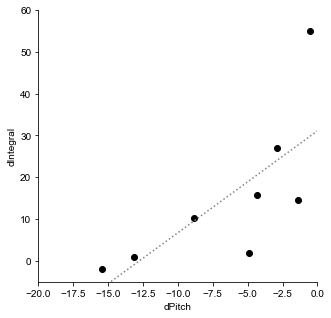

In [552]:
d_int = np.zeros(len(anis))
for a,ani in enumerate(anis):
    d_int[a] = np.nanmean(df_cond[(df_cond['subject']==ani)&(df_cond['condition']=='suture')]['mvmnt_integral'])-\
        np.nanmean(df_cond[(df_cond['subject']==ani)&(df_cond['condition']=='control')]['mvmnt_integral'])

reg = LinearRegression().fit(d_pitch.reshape(-1,1),d_int.reshape(-1,1))
print(reg.score(d_pitch.reshape(-1,1),d_int.reshape(-1,1)),reg.coef_)

fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.scatter(d_pitch,d_int,color='k')
axs.plot(np.arange(-20,5,5),reg.predict(np.arange(-20,5,5).reshape(-1,1)),':',color=[0.5,0.5,0.5])
axs.axis([-20,0,-5,60])
axs.set_xlabel('dPitch')
axs.set_ylabel('dIntegral')
axs = am.xy_axis(axs)

stats.pearsonr(d_pitch,d_int)

0.37066047230218047 [[-403.06161105]]


(-0.608818915854444, 0.10917899073007786)

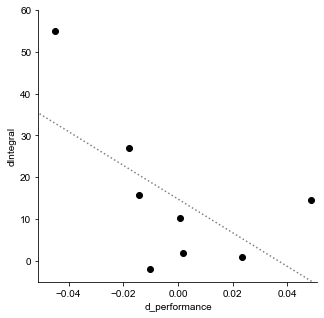

In [553]:
reg = LinearRegression().fit(success.reshape(-1,1),d_int.reshape(-1,1))
print(reg.score(success.reshape(-1,1),d_int.reshape(-1,1)),reg.coef_)

fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.scatter(success,d_int,color='k')
axs.plot(np.arange(-1,1.1,0.1),reg.predict(np.arange(-1,1.1,0.1).reshape(-1,1)),':',color=[0.5,0.5,0.5])
axs.axis([-0.051,0.051,-5,60])
axs.set_xlabel('d_performance')
axs.set_ylabel('dIntegral')
axs = am.xy_axis(axs)

stats.pearsonr(success,d_int)

0.004800317226168915 [[7.90447755]]


(0.06928432164760756, 0.8705070316184562)

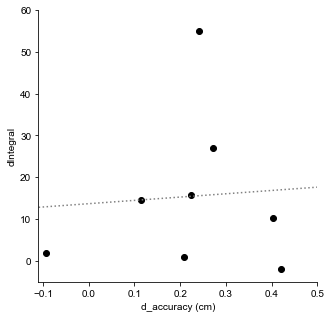

In [575]:
reg = LinearRegression().fit(d_accuracy.reshape(-1,1),d_int.reshape(-1,1))
print(reg.score(d_accuracy.reshape(-1,1),d_int.reshape(-1,1)),reg.coef_)

fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.scatter(d_accuracy,d_int,color='k')
axs.plot(np.arange(-0.2,0.6,0.1),reg.predict(np.arange(-0.2,0.6,0.1).reshape(-1,1)),':',color=[0.5,0.5,0.5])
axs.axis([-0.11,0.5,-5,60])
axs.set_xlabel('d_accuracy (cm)')
axs.set_ylabel('dIntegral')
axs = am.xy_axis(axs)

stats.pearsonr(d_accuracy,d_int)

0.9790438371504842 [[3.70117128]]


(0.9894664406388343, 2.8988658015179435e-06)

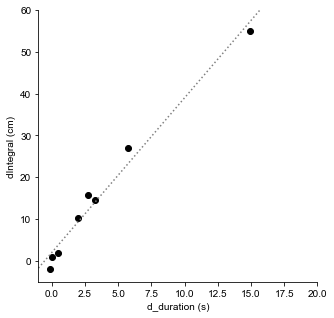

In [561]:
d_dur = np.zeros(len(anis))
for a,ani in enumerate(anis):
    d_dur[a] = np.nanmean(df_cond[(df_cond['subject']==ani)&(df_cond['condition']=='suture')]['trial_duration'])-\
        np.nanmean(df_cond[(df_cond['subject']==ani)&(df_cond['condition']=='control')]['trial_duration'])
        
reg = LinearRegression().fit(d_dur.reshape(-1,1),d_int.reshape(-1,1))
print(reg.score(d_dur.reshape(-1,1),d_int.reshape(-1,1)),reg.coef_)

fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.scatter(d_dur,d_int,color='k')
axs.plot(np.arange(-1,20,5),reg.predict(np.arange(-1,20,5).reshape(-1,1)),':',color=[0.5,0.5,0.5])
axs.axis([-1,20,-5,60])
axs.set_xlabel('d_duration (s)')
axs.set_ylabel('dIntegral (cm)')
axs = am.xy_axis(axs)

stats.pearsonr(d_dur,d_int)

0.4462617272583481 [[0.60324502]]


(0.6680282383689689, 0.07020228150782656)

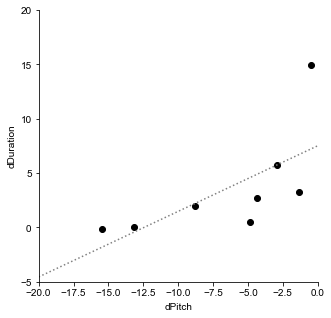

In [563]:
reg = LinearRegression().fit(d_pitch.reshape(-1,1),d_dur.reshape(-1,1))
print(reg.score(d_pitch.reshape(-1,1),d_dur.reshape(-1,1)),reg.coef_)

fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.scatter(d_pitch,d_dur,color='k')
axs.plot(np.arange(-20,5,5),reg.predict(np.arange(-20,5,5).reshape(-1,1)),':',color=[0.5,0.5,0.5])
axs.axis([-20,0,-5,20])
axs.set_xlabel('dPitch')
axs.set_ylabel('dDuration')
axs = am.xy_axis(axs)

stats.pearsonr(d_pitch,d_dur)



0.38173341012099093 [[-109.35163239]]


(-0.6178457818266552, 0.10259235601567442)

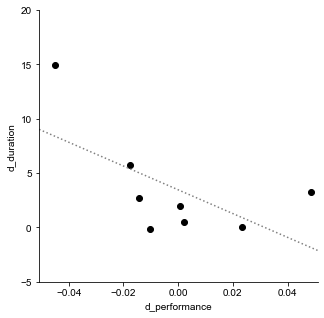

In [565]:
reg = LinearRegression().fit(success.reshape(-1,1),d_dur.reshape(-1,1))
print(reg.score(success.reshape(-1,1),d_dur.reshape(-1,1)),reg.coef_)

fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.scatter(success,d_dur,color='k')
axs.plot(np.arange(-1,1.1,0.1),reg.predict(np.arange(-1,1.1,0.1).reshape(-1,1)),':',color=[0.5,0.5,0.5])
axs.axis([-0.051,0.051,-5,20])
axs.set_xlabel('d_performance')
axs.set_ylabel('d_duration')
axs = am.xy_axis(axs)

stats.pearsonr(success,d_dur)

0.0035648060137027926 [[1.82103393]]


(0.059705996463530406, 0.8883170224745538)

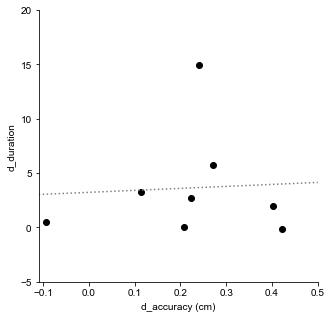

In [576]:
reg = LinearRegression().fit(d_accuracy.reshape(-1,1),d_dur.reshape(-1,1))
print(reg.score(d_accuracy.reshape(-1,1),d_dur.reshape(-1,1)),reg.coef_)

fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.scatter(d_accuracy,d_dur,color='k')
axs.plot(np.arange(-0.2,0.6,0.1),reg.predict(np.arange(-0.2,0.6,0.1).reshape(-1,1)),':',color=[0.5,0.5,0.5])
axs.axis([-0.11,0.5,-5,20])
axs.set_xlabel('d_accuracy (cm)')
axs.set_ylabel('d_duration')
axs = am.xy_axis(axs)

stats.pearsonr(d_accuracy,d_dur)

In [175]:
mvmnt_file = r'T:\jumping_revisions_analysis\df_corrected_pitch_og.h5'
df_side_og = pd.read_hdf(mvmnt_file,key='df')
df_cond = df_side_og[(df_side_og['condition']=='control')|(df_side_og['condition']=='suture')]
df_cond.reset_index(inplace=True,drop=True)

PearsonRResult(statistic=-0.15115934251064023, pvalue=0.7208639661318238)

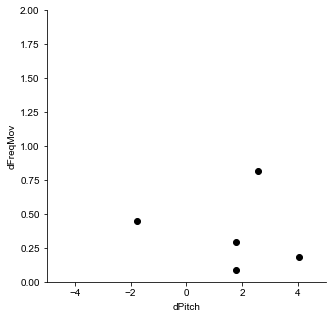

In [176]:
anis = np.unique(df_cond['subject'])
conds = np.unique(df_cond['ocular'])
pitch = np.zeros((len(conds),len(anis)))
for c,cond in enumerate(conds):
    for a,ani in enumerate(anis):
        pitch[c,a] = np.nanmean(df_cond[(df_cond['subject']==ani)&(df_cond['ocular']==cond)]['Side_pitch_mean'])
d_pitch = np.squeeze(np.diff(pitch,axis=0))
d_mov = np.squeeze(np.diff(np.mean(freq,axis=2),axis=0))

fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.scatter(d_pitch,d_mov,color='k')
axs.axis([-5,5,0,2])
axs.set_xlabel('dPitch')
axs.set_ylabel('dFreqMov')
axs = am.xy_axis(axs)

stats.pearsonr(d_pitch,d_mov)

### plot movement timing

In [177]:
fig, ax = am.plot_movement_timing(base_labels,side,cluster_key,condition,0.025,-5,0.5,pwin,plot_params,save_pdf,pp)


### changes in pre-jump positioning

In [ ]:
# calculate pitch by loading in raw DLC points (this takes some time)
# df_corrected_pitch = am.calculate_pitch(df_side_revision,vid_dir)
# df_corrected_pitch.to_hdf(r'T:\jumping_revisions_analysis\df_corrected_pitch.h5',key='df',mode='w')

In [178]:
data_file = r'T:\jumping_revisions_analysis\df_corrected_pitch.h5'
df_pitch = pd.read_hdf(data_file,key='df')


In [179]:
condition = 'ocular'
variable = 'Side_pitch_mean'

df_cond = df_pitch[(df_pitch['condition']=='control')|(df_pitch['condition']=='suture')]
df_cond.reset_index(inplace=True,drop=True)
df_cond = df_cond[(df_cond['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)

fig, axs = plt.subplots(1,1,figsize=(2,2))
axs = am.plot_variable_vs_distance(axs,df_cond,variable,condition,8,24,-50,0,plot_params['bm_col'],save_pdf,pp,suptitle='')
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)
# am.plot_variable_vs_distance_manipulation(df_cond,variable,'success',condition,8,24,plot_params['bm_col'],save_pdf,pp,suptitle='')

fig, axs, p, d_var = am.plot_variable_condition(df_cond,condition,variable,0.9,2.1,-50,0,plot_params['bm_col'],save_pdf,pp)


condition = 'ocular'
variable = 'Side_pitch_std'

df_cond = df_pitch[(df_pitch['condition']=='control')|(df_pitch['condition']=='suture')]
df_cond.reset_index(inplace=True,drop=True)
df_cond = df_cond[(df_cond['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)

fig, axs = plt.subplots(1,1,figsize=(2,2))
axs = am.plot_variable_vs_distance(axs,df_cond,variable,condition,8,24,0,30,plot_params['bm_col'],save_pdf,pp,suptitle='')
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)
# am.plot_variable_vs_distance_manipulation(df_cond,variable,'success',condition,8,24,plot_params['bm_col'],save_pdf,pp,suptitle='')

fig, axs, p, d_var = am.plot_variable_condition(df_cond,condition,variable,0.9,2.1,0,30,plot_params['bm_col'],save_pdf,pp)

binocular -19.76+/-2.39, monocular -26.84+/-3.28, ocular Side_pitch_mean t-test p=0.005
binocular 15.25+/-0.81, monocular 16.79+/-0.72, ocular Side_pitch_std t-test p=0.077


0.441290980426965 [[0.03782604]]
spearman correlation movement freq pitch mn changes p=0.047


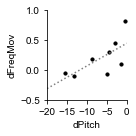

In [180]:
d_mov = np.mean(freq[1,:,:],axis=1)-np.mean(freq[0,:,:],axis=1)

anis = np.unique(df_cond['subject'])
conds = np.unique(df_cond['ocular'])
d_pitch = np.zeros(len(anis))
for a,ani in enumerate(anis):
    d_pitch[a] = np.nanmean(df_cond[(df_cond['subject']==ani)&(df_cond['condition']=='suture')&(df_cond['success']==1)]['Side_pitch_mean'])-\
        np.nanmean(df_cond[(df_cond['subject']==ani)&(df_cond['condition']=='control')&(df_cond['success']==1)]['Side_pitch_mean'])

reg = LinearRegression().fit(d_pitch.reshape(-1,1),d_mov.reshape(-1,1))
print(reg.score(d_pitch.reshape(-1,1),d_mov.reshape(-1,1)),reg.coef_)

fig, axs = plt.subplots(1,1,figsize=(2,2))
axs.plot(np.arange(-20,5,5),reg.predict(np.arange(-20,5,5).reshape(-1,1)),':',color=[0.5,0.5,0.5])
axs.scatter(d_pitch,d_mov,color='k',s=10)

axs.axis([-20,0,-0.5,1.0])
axs.set_xticks(np.arange(-20,5,5))
axs.set_yticks(np.arange(-0.5,1.5,0.5))
axs.set_xlabel('dPitch')
axs.set_ylabel('dFreqMov')
axs = am.xy_axis(axs)


s,p = stats.spearmanr(d_pitch,d_mov)
print('spearman correlation movement freq pitch mn changes p=%0.3f' % p)
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)

0.0054925955317306485 [[-0.00058276]]
0.19437447215773673 [[0.01341535]]


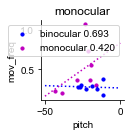

In [181]:
conds = np.unique(df_cond['ocular'])
fig, axs = plt.subplots(1,1,figsize=(2,2))
for c,cond in enumerate(conds):
    pitch = np.zeros(len(anis))
    # accuracy = np.zeros(len(anis))
    for a,ani in enumerate(anis):
        pitch[a] = np.nanmean(df_cond[(df_cond['subject']==ani)&(df_cond['ocular']==cond)&(df_cond['success']==1)]['Side_pitch_mean'])
        # accuracy[a] = np.nanmean(df_cond[(df_cond['subject']==ani)&(df_cond['ocular']==cond)&(df_cond['success']==1)]['accuracy'])

    reg = LinearRegression().fit(pitch.reshape(-1,1),np.mean(freq[c,:,:],axis=1).reshape(-1,1))
    print(reg.score(pitch.reshape(-1,1),np.mean(freq[c,:,:],axis=1).reshape(-1,1)),reg.coef_)

    s, p = stats.spearmanr(pitch,np.mean(freq[c,:,:],axis=1))
    axs.scatter(pitch,np.mean(freq[c,:,:],axis=1),color=plot_params['bm_col'][c],s=10,label='%s %0.3f' % (cond,p))
    axs.plot(np.arange(-50,5,5),reg.predict(np.arange(-50,5,5).reshape(-1,1)),':',color=plot_params['bm_col'][c])
    # axs.axis([-50,0,0,4])
    axs.set_xlabel('pitch')
    axs.set_ylabel('mov_freq')
    axs.set_title(cond)
    axs = am.xy_axis(axs)
    axs.legend()

fig.tight_layout()
if save_pdf:
    pp.savefig(fig)

binocular 17.15+/-2.44, monocular 17.45+/-2.93, ocular Top_yaw_mn t-test p=0.828
0.2450149667479764 [[0.02304496]]
spearman correlation movement freq pitch mean changes p=0.183
binocular 8.33+/-1.45, monocular 16.24+/-4.16, ocular Top_yaw_std t-test p=0.062
0.18966392586061775 [[0.02125644]]
spearman correlation movement freq pitch stdev changes p=0.320


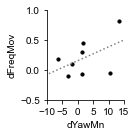

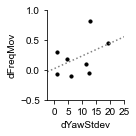

In [182]:
### revision group yaw
yaw_revision = pd.read_hdf(r'T:\jumping_revisions_analysis\yaw_revision_df.h5',key='df')
variable = 'Top_yaw_mn'
condition = 'ocular'

df_cond = yaw_revision[(yaw_revision['condition']=='control')|(yaw_revision['condition']=='suture')]

cond = 'controlopto'
df_cond.reset_index(inplace=True,drop=True)
fig, axs = plt.subplots(1,1,figsize=(2,2))
ax = am.plot_variable_vs_distance(axs,df_cond,variable,condition,8,24,0,40,plot_params['bm_col'],save_pdf,pp,suptitle='')
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

fig, axs, p, d_var = am.plot_variable_condition(df_cond,condition,variable,0.9,2.1,0,40,plot_params['bm_col'],save_pdf,pp)
d_mov = np.mean(freq[1,:,:],axis=1)-np.mean(freq[0,:,:],axis=1)

anis = np.unique(df_cond['subject'])
conds = np.unique(df_cond['ocular'])
d_yaw = np.zeros(len(anis))
for a,ani in enumerate(anis):
    d_yaw[a] = np.nanmean(df_cond[(df_cond['subject']==ani)&(df_cond['condition']=='suture')&(df_cond['success']==1)]['Top_yaw_mn'])-\
        np.nanmean(df_cond[(df_cond['subject']==ani)&(df_cond['condition']=='control')&(df_cond['success']==1)]['Top_yaw_mn'])

reg = LinearRegression().fit(d_yaw.reshape(-1,1),d_mov.reshape(-1,1))
print(reg.score(d_yaw.reshape(-1,1),d_mov.reshape(-1,1)),reg.coef_)

fig, axs = plt.subplots(1,1,figsize=(2,2))
axs.plot(np.arange(-20,20,5),reg.predict(np.arange(-20,20,5).reshape(-1,1)),':',color=[0.5,0.5,0.5])
axs.scatter(d_yaw,d_mov,color='k',s=10)

axs.axis([-10,15,-0.5,1.0])
axs.set_xticks(np.arange(-10,20,5))
axs.set_yticks(np.arange(-0.5,1.5,0.5))
axs.set_xlabel('dYawMn')
axs.set_ylabel('dFreqMov')
axs = am.xy_axis(axs)

s,p = stats.spearmanr(d_yaw,d_mov)
print('spearman correlation movement freq pitch mean changes p=%0.3f' % p)
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)

variable = 'Top_yaw_std'
fig, axs = plt.subplots(1,1,figsize=(2,2))
ax = am.plot_variable_vs_distance(axs,df_cond,variable,condition,8,24,0,40,plot_params['bm_col'],save_pdf,pp,suptitle='')
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

fig, axs, p, d_var = am.plot_variable_condition(df_cond,condition,variable,0.9,2.1,0,40,plot_params['bm_col'],save_pdf,pp)

d_yaw = np.zeros(len(anis))
for a,ani in enumerate(anis):
    d_yaw[a] = np.nanmean(df_cond[(df_cond['subject']==ani)&(df_cond['condition']=='suture')&(df_cond['success']==1)]['Top_yaw_std'])-\
        np.nanmean(df_cond[(df_cond['subject']==ani)&(df_cond['condition']=='control')&(df_cond['success']==1)]['Top_yaw_std'])

reg = LinearRegression().fit(d_yaw.reshape(-1,1),d_mov.reshape(-1,1))
print(reg.score(d_yaw.reshape(-1,1),d_mov.reshape(-1,1)),reg.coef_)

fig, axs = plt.subplots(1,1,figsize=(2,2))
axs.plot(np.arange(-5,35,5),reg.predict(np.arange(-5,35,5).reshape(-1,1)),':',color=[0.5,0.5,0.5])
axs.scatter(d_yaw,d_mov,color='k',s=10)

axs.axis([-2.5,25,-0.5,1.0])
axs.set_xticks(np.arange(0,30,5))
axs.set_yticks(np.arange(-0.5,1.5,0.5))
axs.set_xlabel('dYawStdev')
axs.set_ylabel('dFreqMov')
axs = am.xy_axis(axs)

s,p = stats.spearmanr(d_yaw,d_mov)
print('spearman correlation movement freq pitch stdev changes p=%0.3f' % p)
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)

In [219]:
p

0.18272075053971484

### cluster amplitudes

In [183]:
base_labels = am.get_movement_amplitudes_mm(base_labels,'Side')
fig, axs, amps = am.plot_cluster_amplitudes(base_labels,'hclusters','ocular',0,3,plot_params['bm_col'],save_pdf,pp)

binoc vs. monoc amp cluster 1 p=0.48
binoc vs. monoc amp cluster 2 p=0.45
binoc vs. monoc amp cluster 3 p=0.37
binoc vs. monoc amp cluster 4 p=0.08
binoc vs. monoc amp cluster 5 p=0.61
binoc vs. monoc amp cluster 6 p=0.62
binoc vs. monoc amp cluster 7 p=0.17
binoc vs. monoc amp cluster 8 p=0.61
binoc vs. monoc amp cluster 9 p=0.04
binoc vs. monoc amp cluster 10 p=0.78


In [184]:
n_clust = amps.shape[2]
num_ani = amps.shape[0]
anova_df = pd.DataFrame(columns=['cluster','condition','amps'])

for clust in range(n_clust):
    temp_df = pd.DataFrame(columns=['cluster','condition','amps'])
    temp_df['cluster'] = np.ones(num_ani*2)*clust
    temp_df['condition'] = np.hstack((np.zeros(num_ani),np.ones(num_ani))).astype(int)
    temp_df['amps'] = np.hstack((amps[:,0,clust],amps[:,1,clust]))

    anova_df = pd.concat([anova_df,temp_df])

model = ols('amps ~ C(cluster) + C(condition) + C(cluster):C(condition)', data=anova_df).fit()
print('anova amps as a function of cluster and condition')
print(sm.stats.anova_lm(model, typ=2))

anova amps as a function of cluster and condition
                            sum_sq     df           F        PR(>F)
C(cluster)               40.057834    9.0  192.379531  3.167637e-74
C(condition)              0.031216    1.0    1.349245  2.473867e-01
C(cluster):C(condition)   0.141494    9.0    0.679533  7.264215e-01
Residual                  3.239024  140.0         NaN           NaN


In [185]:
pp.close()

meta NOT subset; don't know how to subset; dropped


# Figure 4

In [296]:
h5file = r'T:\eyecam_data.h5'
df_eyecam = pd.read_hdf(h5file)
df_eyecam['distance_DLC'] = df_eyecam['distance']
df_eyecam['platform_DLC'] = df_eyecam['platform']

jd_sub = []
actual_distance = []
for idx,row in df_eyecam.iterrows():
    TakeFL_x = np.nanmedian(row['Top TakeFL x'])
    LandFR_x = np.nanmedian(row['Top LandFR x'])
    LandFL_x = np.nanmedian(row['Top LandFL x'])
    actual_distance.append((TakeFL_x - np.nanmean([LandFR_x,LandFL_x]))/row['Top_pixpercm'])
    
    jd_sub.append((row['Top TakeFL x'][-1] - row['Top LEye x'][-1])/row['Top_pixpercm'])
df_eyecam['actual_distance'] = actual_distance
df_eyecam['jumpdist'] = df_eyecam['jumpdist'] + jd_sub
df_eyecam = am.get_jump_accuracy(df_eyecam)

finished PDF!


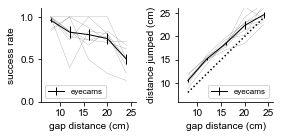

In [38]:
pdf_file = r'G:\My Drive\Niell\Jumping paper\Manuscript\Resubmission\Figures\Figure 4\Figure_4_panels.pdf'
pp = PdfPages(pdf_file)
save_pdf = True

fig, axs = plt.subplots(1,2,figsize=(4,2))
axs = axs.ravel()

ax = axs[0]
ax = am.plot_performance(ax=ax,og_df=df_eyecam,condition='condition',aborts=True,plt_min=6,plt_max=26,color_scheme=plot_params['cond_col'])

ax = axs[1]
ax = am.plot_jumpdist(ax=ax,og_df=df_eyecam,condition='condition',plt_min=6,plt_max=26,color_scheme=plot_params['cond_col'])

fig.tight_layout()

if save_pdf:
    pp.savefig(fig)
    pp.close()
print('finished PDF!')

### compare performance between control and camera conditions

In [326]:
anis = np.unique(df_eyecam['subject'])
df_eyecam = am.aborts_as_failures(df_eyecam)
jumpcurve = df_eyecam.groupby(['distance_DLC','subject']).mean()
jumpcurve.reset_index(inplace=True)
temp_df_eye = jumpcurve[['subject','distance_DLC','success']].copy()
temp_df_eye['condition'] = [1]*temp_df_eye.shape[0]

df = am.aborts_as_failures(df_jump_og[df_jump_og['condition']=='control'])
jumpcurve = df.groupby(['distance_DLC','subject']).mean()
jumpcurve.reset_index(inplace=True)
temp_df_con = jumpcurve[['subject','distance_DLC','success']].copy()
temp_df_con['condition'] = [0]*temp_df_con.shape[0]


anova_df = pd.concat([temp_df_con,temp_df_eye])

for a,ani in enumerate(anis):
    anova_df = anova_df.replace(ani,a)
anova_df

,subject,distance_DLC,success,condition
0,0,8,0.975610,0
1,1,8,0.926471,0
2,2,8,1.000000,0
3,3,8,1.000000,0
4,4,8,0.987500,0
...,...,...,...,...
35,3,24,0.333333,1
36,4,24,0.428571,1
37,5,24,0.250000,1
38,6,24,0.625000,1


In [327]:
stats.ttest_rel(anova_df[anova_df['condition']==0]['success'],anova_df[anova_df['condition']==1]['success']) #paired t-test of all subject/distances

Ttest_relResult(statistic=0.6614537508848344, pvalue=0.5122105850905229)

In [328]:
model = ols('success ~ C(distance_DLC) + C(condition) + C(distance_DLC):C(condition)', data=anova_df).fit() #anova
print(sm.stats.anova_lm(model, typ=2))

                                sum_sq    df          F        PR(>F)
C(distance_DLC)               2.919555   4.0  39.346334  3.115892e-17
C(condition)                  0.006928   1.0   0.373448  5.431104e-01
C(distance_DLC):C(condition)  0.214542   4.0   2.891351  2.825978e-02
Residual                      1.298525  70.0        NaN           NaN


# Figure 5

In [58]:
save_pdf = False

In [286]:
pdf_file = r'G:\My Drive\Niell\Jumping paper\Manuscript\Resubmission\Figures\FIgure 5\Figure_5_panels.pdf'
pp = PdfPages(pdf_file)
save_pdf = True

### plot opto performance curves

In [100]:
### load top-down revision data
data_file = r'T:\jumping_revisions_analysis\df_jumpDLCpoints_corrected.h5'
df_jump_revision = pd.read_hdf(data_file,key='df')

In [72]:
cond = 'controlopto'
df_cond = df_jump_revision[(df_jump_revision['condition']==cond)]
df_cond.reset_index(inplace=True,drop=True)
print('# bino/bino trials: ChR2- %d, ChR2+ %d' % (df_cond[df_cond['expt_group']=='WT'].shape[0],df_cond[df_cond['expt_group']=='ChR2'].shape[0]))

# fig, axs = plt.subplots(2,1,figsize=(2,4))
# axs = am.plot_performance_manipulation(axs=axs,df=df_cond,condition='expt_group',manipulation='laser_trial',aborts=True,plt_min=8,plt_max=24,color_scheme=plot_params['laser_col'])

# fig.tight_layout()
# if save_pdf:
#     pp.savefig(fig)
#     plt.close(fig)

cond = 'sutureopto'
df_cond = df_jump_revision[(df_jump_revision['condition']==cond)]
df_cond.reset_index(inplace=True,drop=True)
print('# mono/bino trials: ChR2- %d, ChR2+ %d' % (df_cond[df_cond['expt_group']=='WT'].shape[0],df_cond[df_cond['expt_group']=='ChR2'].shape[0]))

# fig, axs = plt.subplots(2,1,figsize=(2,4))
# axs = am.plot_performance_manipulation(axs=axs,df=df_cond,condition='expt_group',manipulation='laser_trial',aborts=True,plt_min=8,plt_max=24,color_scheme=plot_params['laser_col'])

# fig.tight_layout()
# if save_pdf:
#     pp.savefig(fig)
#     plt.close(fig)

# bino/bino trials: ChR2- 948, ChR2+ 911
# mono/bino trials: ChR2- 670, ChR2+ 601


In [289]:
# ### import old data
# key_keys = ['subject', 'expdate', 'condition', 'ocular','laser_trial','success', 'platform', 'distance','jumpdist']
# cohort3_path = r'\\sendak\C\Users\nlab\Box Sync\Phil Niell Lab\Behavior\Jumping task\analysis\old_cohorts'
# cohort3_df = 'thirdGendf.pkl'
# # cohort3_labels = 'thirdGenlabels.pkl'
# c3_df = pd.read_pickle(os.path.join(cohort3_path,cohort3_df))
# # c3_labels = pd.read_pickle(os.path.join(cohort3_path,cohort3_labels))
# c3_df = c3_df[key_keys]
# c3_df['laser_trial'] = c3_df['laser_trial'].astype(str)
# c3_df[c3_df['laser_trial']=='0'] = c3_df[c3_df['laser_trial']=='0'].replace('0','laser off')
# c3_df[c3_df['laser_trial']=='1'] = c3_df[c3_df['laser_trial']=='1'].replace('1','laser on')

# pwin = 0.25 #half the movement duration window desired
# metric = 'velocity'
# mvmnt_file = r'T:\variable_platform_mvmnts_%sms_%s.h5' % (int(pwin*1000),metric)
# df_pickle = mvmnt_file[:-3] + '_df.h5'
# # labels_pickle = mvmnt_file[:-3] + '_labels.h5'
# df_clust = pd.read_hdf(df_pickle)
# # labels_all = pd.read_hdf(labels_pickle)

# ###### opto analysis with old cohort added in
# c4_df = df_clust.copy()
# c4_df = c4_df[c4_df['condition']=='opto suture']
# c4_df.reset_index(inplace=True,drop=True)
# c4_labels = labels_all.copy()
# # c4_labels = c4_labels[c4_labels['condition']=='opto suture']
# # c4_labels.reset_index(inplace=True,drop=True)

# # opto_df = pd.concat([c4_df,c3_df],axis=0,ignore_index=True)
# opto_df = c4_df.copy()
# opto_df.reset_index(inplace=True,drop=True)
# opto_df = opto_df[opto_df['subject']!='PV-ChR8.7ALN'] #this animal had no laser on data? threw out before opto experiments?
# opto_df.reset_index(inplace=True,drop=True)

# opto_df['platform_DLC'] = opto_df['platform']
# opto_df['distance_DLC'] = opto_df['distance']

# expt_group = []
# for index,row in opto_df.iterrows():
#     if 'PV' in str(row['subject']):
#         expt_group.append('ChR2')
#     else:
#         expt_group.append('WT')
# opto_df['expt_group'] = expt_group

# fig, axs = plt.subplots(2,1,figsize=(2,4))
# axs = am.plot_performance_manipulation(axs=axs,df=opto_df,condition='expt_group',manipulation='laser_trial',aborts=True,plt_min=6,plt_max=26,color_scheme=plot_params['laser_col'])
# fig.tight_layout()

# if save_pdf:
#     pp.savefig(fig)
#     plt.close(fig)
# # ###control group
# # opto_control_df = opto_df[opto_df['subject'].str.contains('J')]
# # opto_control_df.reset_index(inplace=True,drop=True)
# # opto_control_labels = opto_labels[opto_labels['subject'].str.contains('J')]
# # opto_control_labels.reset_index(inplace=True,drop=True)
# # opto_control_df = opto_control_df[key_keys]

# # ###experimental group
# # opto_expt_df = opto_df[opto_df['subject'].str.contains('PV')]
# # opto_expt_df.reset_index(inplace=True,drop=True)
# # opto_expt_labels = opto_labels[opto_labels['subject'].str.contains('PV')]
# # opto_expt_labels.reset_index(inplace=True,drop=True)
# # opto_expt_df = opto_expt_df[key_keys]
# # opto_expt_df = pd.concat([opto_expt_df,c3_df],axis=0,ignore_index=True)
# # # opto_expt_df = c3_df.copy()
# # opto_expt_df = opto_expt_df[opto_expt_df['subject']!='PV-ChR8.7ALN'] #this animal had no laser on data? threw out before opto experiments?
# # opto_expt_df.reset_index(inplace=True,drop=True)

# # # opto_expt_df = opto_expt_df[(opto_expt_df['distance']==8)|(opto_expt_df['distance']==12)|(opto_expt_df['distance']==16)]

# # df_list = [opto_control_df,opto_expt_df]
# # labels_list = [opto_control_labels,opto_expt_labels]
# # opto_list = ['control','PVChR2']

# # cluster_key = 'hclusters'
# # condition = 'laser_trial'
# # side = 'Side'

# # for i in range(2):
# #     ## Set up group plot PDF file if save_pdf=True
# #     if save_pdf:
# #         pdf_file = 'T:\opto_%s_group_plots_%dclusts_aborts_newonly.pdf' % (opto_list[i],n_k)
# #         pp = PdfPages(pdf_file)
# #     else:
# #         pp=[]

# #     # Analyze movements from kmeans clustering of PCA data (group, individual)
# # #     fig, ax = am.plot_movement_clusters(df_list[i],labels_list[i],side,cluster_key,condition,plot_params,save_pdf,pp)
# # #     fig, ax = am.plot_cluster_freq(df_list[i],labels_list[i],cluster_key,condition,plot_params,save_pdf,pp)
# # #     fig, ax = am.plot_movement_timing(labels_list[i],side,cluster_key,condition,-5,2,0.5,plot_params,save_pdf,pp)

# # #     for cluster_num in range(n_k):
# # #         fig, ax = am.plot_movement_trace_distance(labels_list[i],side,cluster_num,cluster_key,condition,plot_params,save_pdf,pp)
# # #         base_df = am.label_bob_frequency(df_list[i],labels_list[i],cluster_key,cluster_num)
# # #         fig, ax = am.plot_performance_bob_freq(df_list[i],condition,'bob_freq',4,save_pdf,pp,'')

# #     ### create lists of platform widths and gap distances to get retinal image size
# # #     pfs = np.around(np.array([4,8,12])*2.54,decimals=1)
# # #     ds = np.around(np.arange(8,28,4),decimals=1)
# # #     ris, fig, ax = am.make_ris_table(pfs,ds,save_pdf,pp)

# #     print(opto_list[i])
# #     aborts=1
# #     fig, ax, stats_array = am.plot_performance(df_list[i],condition,aborts,5,25,plot_params,save_pdf,pp)
# #     fig, ax = am.plot_jump_accuracy(df_list[i],condition,'success',plot_params,save_pdf,pp,'accuracy vs. success')
# #     fig, ax = am.plot_jumpdist(df_list[i],condition,5,25,plot_params,save_pdf,pp)
# #     fig, ax = am.plot_performance_platforms(df_list[i],condition,aborts,5,25,plot_params,save_pdf,pp)
# # #     fig, ax = am.plot_ris_distance(df_list[i],condition,ris,plot_params,save_pdf,pp)
# #     fig, ax = am.plot_jumpdist_platforms(df_list[i],condition,5,25,plot_params,save_pdf,pp)

# #     # ### close the group PDF
# #     # try:
# #     #     pp.close()
# #     # except:
# #     #     pass
# #     # print('finished plotting opto %s group data!' % opto_list[i])
# #     # print('')

In [73]:
### load top-down monoc/monoc data
data_file = r'T:\df_jumpDLCpts.h5'
df_jump_og = pd.read_hdf(data_file,key='df')
df_jump_og['platform_DLC'] = df_jump_og['platform']
df_jump_og['distance_DLC'] = df_jump_og['distance']

expt_group = []
for index,row in df_jump_og.iterrows():
    if 'PV' in str(row['subject']):
        expt_group.append('ChR2')
    else:
        expt_group.append('WT')
df_jump_og['expt_group'] = expt_group

df_cond = df_jump_og[(df_jump_og['condition']=='opto suture')]#|(df_jump_og['condition']=='suture_background_opto_450nm_40Hz')|(df_jump_og['condition']=='suture_background_opto_450nm_continuous')]
df_cond.reset_index(inplace=True,drop=True)

# fig, axs = plt.subplots(2,1,figsize=(2,4))
# axs = am.plot_performance_manipulation(axs=axs,df=df_jump_og,condition='expt_group',manipulation='laser_trial',aborts=True,plt_min=6,plt_max=26,color_scheme=plot_params['laser_col'])
# fig.tight_layout()
# if save_pdf:
#     pp.savefig(fig)
#     plt.close(fig)


### plot opto changes in landing

laser off vs. on std position p=0.328
binoc/binoc WT vs ChR2 mean p=0.019
binoc/binoc WT vs ChR2 std p=0.249
laser off vs. on std position p=0.955
monoc/binoc WT vs ChR2 mean p=0.189
monoc/binoc WT vs ChR2 std p=0.955
laser off vs. on std position p=0.219
monoc/monoc WT vs ChR2 mean p=0.189
monoc/monoc WT vs ChR2 std p=0.200


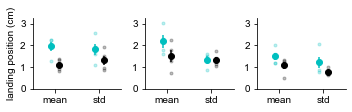

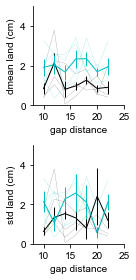

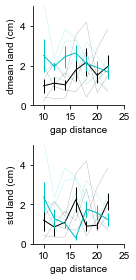

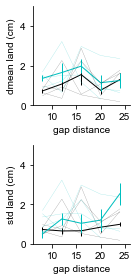

In [70]:
condition = 'laser_trial'

jfig,jax = plt.subplots(1,3,figsize=(5,1.5))

cond = 'controlopto'
df_cond = df_jump_revision[(df_jump_revision['condition']==cond)&(df_jump_revision['success']==1)]
df_cond.reset_index(inplace=True,drop=True)

fig, axs = plt.subplots(2,1,figsize=(2,4))
axs, mn_land_x_diff, mn_land_y_diff, mn_land_xy_diff, std_land_x, std_land_y, std_land_xy_diff = am.plot_landing_position_change_mean(axs,df_cond,condition,8,24,0,5,plot_params['laser_col'])
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

ax = jax[0]
chmean= np.nanmean(mn_land_xy_diff[:,1,:],axis=0)
chstd = np.nanmean(std_land_xy_diff[:,1,:],axis=0)
ax.plot([0.9]*4,chmean,ls='none',marker='o',color='c',markersize=3,alpha=0.25)
ax.plot([1.9]*4,chstd,ls='none',marker='o',color='c',markersize=3,alpha=0.25)
ax.errorbar(x=[0.9, 1.9],y=[np.nanmean(chmean),np.nanmean(chstd)],yerr=[np.nanstd(chmean)/np.sqrt(4),np.nanstd(chstd)/np.sqrt(4)],ls='none',marker='o',color='c')


wtmean= np.nanmean(mn_land_xy_diff[:,0,:],axis=0)
wtstd = np.nanmean(std_land_xy_diff[:,0,:],axis=0)
ax.plot([1.1]*4,wtmean,ls='none',marker='o',color='k',markersize=3,alpha=0.25)
ax.plot([2.1]*4,wtstd,ls='none',marker='o',color='k',markersize=3,alpha=0.25)
ax.errorbar(x=[1.1, 2.1],y=[np.nanmean(wtmean),np.nanmean(wtstd)],yerr=[np.nanstd(wtmean)/np.sqrt(4),np.nanstd(wtstd)/np.sqrt(4)],ls='none',marker='o',color='k')
ax.set_xticks([1,2])
ax.set_xticklabels(['mean','std'])
ax.axis([0.5,2.5,0,3.25])
ax.set_yticks([0,1,2,3])
ax.set_ylabel('landing position (cm)')
ax = am.xy_axis(ax)

# s,p = stats.ttest_1samp(wtmean,0)
# print('binoc/binoc WT laser on/off mean p=%0.3f' % p)
# s,p = stats.ttest_1samp(chmean,0)
# print('binoc/binoc ChR2 laser on/off mean p=%0.3f' % p)
# s,p = stats.ttest_1samp(wtstd,0)
# print('binoc/binoc WT laser on/off std p=%0.3f' % p)
# s,p = stats.ttest_1samp(chstd,0)
# print('binoc/binoc ChR2 laser on/off std p=%0.3f' % p)

s,p = stats.ttest_ind(wtmean,chmean)
print('binoc/binoc WT vs ChR2 mean p=%0.3f' % p)
s,p = stats.ttest_ind(wtstd,chstd)
print('binoc/binoc WT vs ChR2 std p=%0.3f' % p)

cond = 'sutureopto'
df_cond = df_jump_revision[(df_jump_revision['condition']==cond)&(df_jump_revision['success']==1)]
df_cond.reset_index(inplace=True,drop=True)

fig, axs = plt.subplots(2,1,figsize=(2,4))
axs, mn_land_x_diff, mn_land_y_diff, mn_land_xy_diff, std_land_x, std_land_y, std_land_xy_diff = am.plot_landing_position_change_mean(axs,df_cond,condition,8,24,0,5,plot_params['laser_col'])
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

ax = jax[1]
chmean= np.nanmean(mn_land_xy_diff[:,1,:],axis=0)
chstd = np.nanmean(std_land_xy_diff[:,1,:],axis=0)
ax.plot([0.9]*4,chmean,ls='none',marker='o',color='c',markersize=3,alpha=0.25)
ax.plot([1.9]*4,chstd,ls='none',marker='o',color='c',markersize=3,alpha=0.25)
ax.errorbar(x=[0.9, 1.9],y=[np.nanmean(chmean),np.nanmean(chstd)],yerr=[np.nanstd(chmean)/np.sqrt(4),np.nanstd(chstd)/np.sqrt(4)],ls='none',marker='o',color='c')

wtmean= np.nanmean(mn_land_xy_diff[:,0,:],axis=0)
wtstd = np.nanmean(std_land_xy_diff[:,0,:],axis=0)
ax.plot([1.1]*4,wtmean,ls='none',marker='o',color='k',markersize=3,alpha=0.25)
ax.plot([2.1]*4,wtstd,ls='none',marker='o',color='k',markersize=3,alpha=0.25)
ax.errorbar(x=[1.1, 2.1],y=[np.nanmean(wtmean),np.nanmean(wtstd)],yerr=[np.nanstd(wtmean)/np.sqrt(4),np.nanstd(wtstd)/np.sqrt(4)],ls='none',marker='o',color='k')
ax.set_xticks([1,2])
ax.set_xticklabels(['mean','std'])
ax.axis([0.5,2.5,0,3.25])
ax.set_yticks([0,1,2,3])
ax = am.xy_axis(ax)

s,p = stats.ttest_ind(wtmean,chmean)
print('monoc/binoc WT vs ChR2 mean p=%0.3f' % p)
s,p = stats.ttest_ind(wtstd,chstd)
print('monoc/binoc WT vs ChR2 std p=%0.3f' % p)

### monocular opto in monocular V1
cond = 'opto suture'
df_cond = df_jump_og[(df_jump_og['condition']==cond)&(df_jump_og['success']==1)]
df_cond.reset_index(inplace=True,drop=True)

fig, axs = plt.subplots(2,1,figsize=(2,4))
axs, mn_land_x_diff, mn_land_y_diff, mn_land_xy_diff, std_land_x, std_land_y, std_land_xy_diff = am.plot_landing_position_change_mean_og(axs,df_cond,condition,6,26,0,5,plot_params['laser_col'])
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

ax = jax[2]
chmean= np.nanmean(mn_land_xy_diff[:,1,:],axis=0)
chstd = np.nanmean(std_land_xy_diff[:,1,:],axis=0)
ax.plot([0.9]*4,chmean,ls='none',marker='o',color='c',markersize=3,alpha=0.25)
ax.plot([1.9]*4,chstd,ls='none',marker='o',color='c',markersize=3,alpha=0.25)
ax.errorbar(x=[0.9, 1.9],y=[np.nanmean(chmean),np.nanmean(chstd)],yerr=[np.nanstd(chmean)/np.sqrt(4),np.nanstd(chstd)/np.sqrt(4)],ls='none',marker='o',color='c')

wtmean= np.nanmean(mn_land_xy_diff[:,0,:],axis=0)
wtstd = np.nanmean(std_land_xy_diff[:,0,:],axis=0)
ax.plot([1.1]*4,wtmean,ls='none',marker='o',color='k',markersize=3,alpha=0.25)
ax.plot([2.1]*4,wtstd,ls='none',marker='o',color='k',markersize=3,alpha=0.25)
ax.errorbar(x=[1.1, 2.1],y=[np.nanmean(wtmean),np.nanmean(wtstd)],yerr=[np.nanstd(wtmean)/np.sqrt(4),np.nanstd(wtstd)/np.sqrt(4)],ls='none',marker='o',color='k')
ax.set_xticks([1,2])
ax.set_xticklabels(['mean','std'])
ax.axis([0.5,2.5,0,3.25])
ax.set_yticks([0,1,2,3])
ax = am.xy_axis(ax)

s,p = stats.ttest_ind(wtmean,chmean)
print('monoc/monoc WT vs ChR2 mean p=%0.3f' % p)
s,p = stats.ttest_ind(wtstd,chstd)
print('monoc/monoc WT vs ChR2 std p=%0.3f' % p)

jfig.tight_layout()
if save_pdf:
    pp.savefig(jfig)

laser off vs. on std position p=0.328
laser off vs. on std position p=0.955
laser off vs. on std position p=0.219


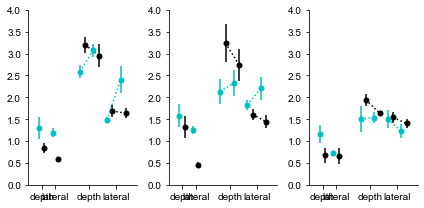

In [292]:
condition = 'laser_trial'

jfig,jax = plt.subplots(1,3,figsize=(6,3))

cond = 'controlopto'
df_cond = df_jump_revision[(df_jump_revision['condition']==cond)&(df_jump_revision['success']==1)]
df_cond.reset_index(inplace=True,drop=True)

fig, axs = plt.subplots(2,1,figsize=(2,4))
axs, mn_land_x_diff, mn_land_y_diff, mn_land_xy_diff, std_land_x, std_land_y, std_land_xy_diff = am.plot_landing_position_change_mean(axs,df_cond,condition,8,24,0,4,plot_params['laser_col'])
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

ax = jax[0]

chmeanx= np.nanmean(mn_land_x_diff[:,0,:],axis=0)
chmeany= np.nanmean(mn_land_y_diff[:,0,:],axis=0)
chstdxoff = np.nanmean(std_land_x[:,0,0,:],axis=0)
chstdxon = np.nanmean(std_land_x[:,1,0,:],axis=0)
chstdyoff = np.nanmean(std_land_y[:,0,0,:],axis=0)
chstdyon = np.nanmean(std_land_y[:,1,0,:],axis=0)
# ax.plot(np.ones(4)*1.2,chmeanx,'ko',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*2.2,chmeany,'ko',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*4.2,chstdxoff,'ko',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*5.2,chstdxon,'ko',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*6.2,chstdyoff,'ko',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*7.2,chstdyon,'ko',markersize=3,alpha=0.25)
ax.errorbar(x=[1.2, 2.2],y=[np.nanmean(chmeanx),np.nanmean(chmeany)],yerr=[np.nanstd(chmeanx)/np.sqrt(4),np.nanstd(chmeany)/np.sqrt(4)],ls='none',marker='o',color='k',markersize=5)
ax.errorbar(x=[4.2, 5.2],y=[np.nanmean(chstdxoff),np.nanmean(chstdxon)],yerr=[np.nanstd(chstdxoff)/np.sqrt(4),np.nanstd(chstdxon)/np.sqrt(4)],ls=':',marker='o',color='k',markersize=5)
ax.errorbar(x=[6.2, 7.2],y=[np.nanmean(chstdyoff),np.nanmean(chstdyon)],yerr=[np.nanstd(chstdyoff)/np.sqrt(4),np.nanstd(chstdyon)/np.sqrt(4)],ls=':',marker='o',color='k',markersize=5)

chmeanx= np.nanmean(mn_land_x_diff[:,1,:],axis=0)
chmeany= np.nanmean(mn_land_y_diff[:,1,:],axis=0)
chstdxoff = np.nanmean(std_land_x[:,0,1,:],axis=0)
chstdxon = np.nanmean(std_land_x[:,1,1,:],axis=0)
chstdyoff = np.nanmean(std_land_y[:,0,1,:],axis=0)
chstdyon = np.nanmean(std_land_y[:,1,1,:],axis=0)
# ax.plot(np.ones(4)*0.8,chmeanx,'co',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*1.8,chmeany,'co',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*3.8,chstdxoff,'co',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*4.8,chstdxon,'co',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*5.8,chstdyoff,'co',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*6.8,chstdyon,'co',markersize=3,alpha=0.25)
ax.errorbar(x=[0.8, 1.8],y=[np.nanmean(chmeanx),np.nanmean(chmeany)],yerr=[np.nanstd(chmeanx)/np.sqrt(4),np.nanstd(chmeany)/np.sqrt(4)],ls='none',marker='o',color='c',markersize=5)
ax.errorbar(x=[3.8, 4.8],y=[np.nanmean(chstdxoff),np.nanmean(chstdxon)],yerr=[np.nanstd(chstdxoff)/np.sqrt(4),np.nanstd(chstdxon)/np.sqrt(4)],ls=':',marker='o',color='c',markersize=5)
ax.errorbar(x=[5.8, 6.8],y=[np.nanmean(chstdyoff),np.nanmean(chstdyon)],yerr=[np.nanstd(chstdyoff)/np.sqrt(4),np.nanstd(chstdyon)/np.sqrt(4)],ls=':',marker='o',color='c',markersize=5)

ax.set_xticks([1,2,4.5,6.5])
ax.set_xticklabels(['depth','lateral','depth','lateral'])
ax.axis([0,8,0,4])
ax = am.xy_axis(ax)


cond = 'sutureopto'
df_cond = df_jump_revision[(df_jump_revision['condition']==cond)&(df_jump_revision['success']==1)]
df_cond.reset_index(inplace=True,drop=True)

fig, axs = plt.subplots(2,1,figsize=(2,4))
axs, mn_land_x_diff, mn_land_y_diff, mn_land_xy_diff, std_land_x, std_land_y, std_land_xy_diff = am.plot_landing_position_change_mean(axs,df_cond,condition,8,24,0,4,plot_params['laser_col'])
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

ax = jax[1]

chmeanx= np.nanmean(mn_land_x_diff[:,0,:],axis=0)
chmeany= np.nanmean(mn_land_y_diff[:,0,:],axis=0)
chstdxoff = np.nanmean(std_land_x[:,0,0,:],axis=0)
chstdxon = np.nanmean(std_land_x[:,1,0,:],axis=0)
chstdyoff = np.nanmean(std_land_y[:,0,0,:],axis=0)
chstdyon = np.nanmean(std_land_y[:,1,0,:],axis=0)
# ax.plot(np.ones(4)*1.2,chmeanx,'ko',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*2.2,chmeany,'ko',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*4.2,chstdxoff,'ko',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*5.2,chstdxon,'ko',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*6.2,chstdyoff,'ko',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*7.2,chstdyon,'ko',markersize=3,alpha=0.25)
ax.errorbar(x=[1.2, 2.2],y=[np.nanmean(chmeanx),np.nanmean(chmeany)],yerr=[np.nanstd(chmeanx)/np.sqrt(4),np.nanstd(chmeany)/np.sqrt(4)],ls='none',marker='o',color='k',markersize=5)
ax.errorbar(x=[4.2, 5.2],y=[np.nanmean(chstdxoff),np.nanmean(chstdxon)],yerr=[np.nanstd(chstdxoff)/np.sqrt(4),np.nanstd(chstdxon)/np.sqrt(4)],ls=':',marker='o',color='k',markersize=5)
ax.errorbar(x=[6.2, 7.2],y=[np.nanmean(chstdyoff),np.nanmean(chstdyon)],yerr=[np.nanstd(chstdyoff)/np.sqrt(4),np.nanstd(chstdyon)/np.sqrt(4)],ls=':',marker='o',color='k',markersize=5)
chmeanx= np.nanmean(mn_land_x_diff[:,1,:],axis=0)
chmeany= np.nanmean(mn_land_y_diff[:,1,:],axis=0)
chstdxoff = np.nanmean(std_land_x[:,0,1,:],axis=0)
chstdxon = np.nanmean(std_land_x[:,1,1,:],axis=0)
chstdyoff = np.nanmean(std_land_y[:,0,1,:],axis=0)
chstdyon = np.nanmean(std_land_y[:,1,1,:],axis=0)
# ax.plot(np.ones(4)*0.8,chmeanx,'co',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*1.8,chmeany,'co',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*3.8,chstdxoff,'co',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*4.8,chstdxon,'co',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*5.8,chstdyoff,'co',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*6.8,chstdyon,'co',markersize=3,alpha=0.25)
ax.errorbar(x=[0.8, 1.8],y=[np.nanmean(chmeanx),np.nanmean(chmeany)],yerr=[np.nanstd(chmeanx)/np.sqrt(4),np.nanstd(chmeany)/np.sqrt(4)],ls='none',marker='o',color='c',markersize=5)
ax.errorbar(x=[3.8, 4.8],y=[np.nanmean(chstdxoff),np.nanmean(chstdxon)],yerr=[np.nanstd(chstdxoff)/np.sqrt(4),np.nanstd(chstdxon)/np.sqrt(4)],ls=':',marker='o',color='c',markersize=5)
ax.errorbar(x=[5.8, 6.8],y=[np.nanmean(chstdyoff),np.nanmean(chstdyon)],yerr=[np.nanstd(chstdyoff)/np.sqrt(4),np.nanstd(chstdyon)/np.sqrt(4)],ls=':',marker='o',color='c',markersize=5)

ax.set_xticks([1,2,4.5,6.5])
ax.set_xticklabels(['depth','lateral','depth','lateral'])
ax.axis([0,8,0,4])
ax = am.xy_axis(ax)


### monocular opto in monocular V1
cond = 'opto suture'
df_cond = df_jump_og[(df_jump_og['condition']==cond)&(df_jump_og['success']==1)]
df_cond.reset_index(inplace=True,drop=True)

fig, axs = plt.subplots(2,1,figsize=(2,4))
axs, mn_land_x_diff, mn_land_y_diff, mn_land_xy_diff, std_land_x, std_land_y, std_land_xy_diff = am.plot_landing_position_change_mean_og(axs,df_cond,condition,6,26,0,4,plot_params['laser_col'])
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

ax = jax[2]

chmeanx= np.nanmean(mn_land_x_diff[:,0,:],axis=0)
chmeany= np.nanmean(mn_land_y_diff[:,0,:],axis=0)
chstdxoff = np.nanmean(std_land_x[:,0,0,:],axis=0)
chstdxon = np.nanmean(std_land_x[:,1,0,:],axis=0)
chstdyoff = np.nanmean(std_land_y[:,0,0,:],axis=0)
chstdyon = np.nanmean(std_land_y[:,1,0,:],axis=0)
# ax.plot(np.ones(4)*1.2,chmeanx,'ko',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*2.2,chmeany,'ko',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*4.2,chstdxoff,'ko',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*5.2,chstdxon,'ko',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*6.2,chstdyoff,'ko',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*7.2,chstdyon,'ko',markersize=3,alpha=0.25)
ax.errorbar(x=[1.2, 2.2],y=[np.nanmean(chmeanx),np.nanmean(chmeany)],yerr=[np.nanstd(chmeanx)/np.sqrt(4),np.nanstd(chmeany)/np.sqrt(4)],ls='none',marker='o',color='k',markersize=5)
ax.errorbar(x=[4.2, 5.2],y=[np.nanmean(chstdxoff),np.nanmean(chstdxon)],yerr=[np.nanstd(chstdxoff)/np.sqrt(4),np.nanstd(chstdxon)/np.sqrt(4)],ls=':',marker='o',color='k',markersize=5)
ax.errorbar(x=[6.2, 7.2],y=[np.nanmean(chstdyoff),np.nanmean(chstdyon)],yerr=[np.nanstd(chstdyoff)/np.sqrt(4),np.nanstd(chstdyon)/np.sqrt(4)],ls=':',marker='o',color='k',markersize=5)

chmeanx= np.nanmean(mn_land_x_diff[:,1,:],axis=0)
chmeany= np.nanmean(mn_land_y_diff[:,1,:],axis=0)
chstdxoff = np.nanmean(std_land_x[:,0,1,:],axis=0)
chstdxon = np.nanmean(std_land_x[:,1,1,:],axis=0)
chstdyoff = np.nanmean(std_land_y[:,0,1,:],axis=0)
chstdyon = np.nanmean(std_land_y[:,1,1,:],axis=0)
# ax.plot(np.ones(4)*0.8,chmeanx,'co',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*1.8,chmeany,'co',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*3.8,chstdxoff,'co',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*4.8,chstdxon,'co',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*5.8,chstdyoff,'co',markersize=3,alpha=0.25)
# ax.plot(np.ones(4)*6.8,chstdyon,'co',markersize=3,alpha=0.25)
ax.errorbar(x=[0.8, 1.8],y=[np.nanmean(chmeanx),np.nanmean(chmeany)],yerr=[np.nanstd(chmeanx)/np.sqrt(4),np.nanstd(chmeany)/np.sqrt(4)],ls='none',marker='o',color='c',markersize=5)
ax.errorbar(x=[3.8, 4.8],y=[np.nanmean(chstdxoff),np.nanmean(chstdxon)],yerr=[np.nanstd(chstdxoff)/np.sqrt(4),np.nanstd(chstdxon)/np.sqrt(4)],ls=':',marker='o',color='c',markersize=5)
ax.errorbar(x=[5.8, 6.8],y=[np.nanmean(chstdyoff),np.nanmean(chstdyon)],yerr=[np.nanstd(chstdyoff)/np.sqrt(4),np.nanstd(chstdyon)/np.sqrt(4)],ls=':',marker='o',color='c',markersize=5)

ax.set_xticks([1,2,4.5,6.5])
ax.set_xticklabels(['depth','lateral','depth','lateral'])
ax.axis([0,8,0,4])
ax = am.xy_axis(ax)

jfig.tight_layout()
if save_pdf:
    pp.savefig(jfig)

### opto changes in movement clusters

In [98]:
pwin = 0.25 #half the movement duration window desired
# metric = 'position'
metric = 'velocity'
mvmnt_file = r'T:\jumping_revisions_analysis\hclusters_revision_mvmnts_1cmY_250ms_velocity.h5' #% (int(pwin*1000),metric)
df_pickle = mvmnt_file[:-3] + '_df.h5'
labels_pickle = mvmnt_file[:-3] + '_labels.h5'
df_all = pd.read_hdf(df_pickle,key='df')
labels_all = pd.read_hdf(labels_pickle,key='df')

group_label = {'PVCHA6LN':'WT','PVCHA6LT':'WT','PVCHA6RT':'ChR2','PVCHA7LN':'ChR2','PVCHA7LT':'WT','PVCHA7RN':'ChR2','PVCHA7RT':'ChR2','PVCHA7TT':'WT'}
expt_group = []
for index,row in df_all.iterrows():
    expt_group.append(group_label[row['subject']])
df_all['expt_group'] = expt_group
expt_group = []
for index,row in labels_all.iterrows():
    expt_group.append(group_label[row['subject']])
labels_all['expt_group'] = expt_group

labels_all = am.get_movement_amplitudes_mm(labels_all,'Side')


cluster 1 p=0.125
cluster 2 p=0.125
cluster 3 p=0.125
cluster 4 p=0.875
cluster 5 p=0.125
cluster 6 p=0.125
cluster 7 p=0.125
cluster 8 p=0.625
cluster 9 p=0.875
cluster 10 p=0.125
anova frequency as a function of cluster and condition
                            sum_sq    df          F        PR(>F)
C(cluster)               11.289407   9.0  13.897755  9.235268e-12
C(condition)              0.242723   1.0   2.689219  1.062624e-01
C(cluster):C(condition)   0.190231   9.0   0.234182  9.880901e-01
Residual                  5.415458  60.0        NaN           NaN
binoc vs. monoc amp cluster 1 p=0.37
binoc vs. monoc amp cluster 2 p=0.45
binoc vs. monoc amp cluster 3 p=0.72
binoc vs. monoc amp cluster 4 p=0.38
binoc vs. monoc amp cluster 5 p=nan
binoc vs. monoc amp cluster 6 p=0.39
binoc vs. monoc amp cluster 7 p=0.19
binoc vs. monoc amp cluster 8 p=0.65
binoc vs. monoc amp cluster 9 p=0.78
binoc vs. monoc amp cluster 10 p=0.28
anova amps as a function of cluster and condition
              

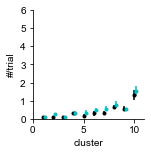

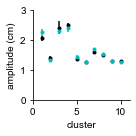

In [99]:
#binoc opto
cond = 'controlopto'
df_cond = df_all[(df_all['condition']==cond)&(df_all['expt_group']=='ChR2')]
df_cond.reset_index(inplace=True,drop=True)
labels_cond = labels_all[(labels_all['condition']==cond)&(labels_all['expt_group']=='ChR2')]
labels_all.reset_index(inplace=True,drop=True)

fig, axs = plt.subplots(1,1,figsize=(2,2))
axs, freq = am.plot_cluster_freq(axs,df_cond,labels_cond,'hclusters','laser_trial',0,6,plot_params['laser_col'],save_pdf,pp)

n_clust = freq.shape[2]
num_ani = freq.shape[1]
anova_df = pd.DataFrame(columns=['cluster','condition','frequency'])

for clust in range(n_clust):
    temp_df = pd.DataFrame(columns=['cluster','condition','frequency'])
    temp_df['cluster'] = np.ones(num_ani*2)*clust
    temp_df['condition'] = np.hstack((np.zeros(num_ani),np.ones(num_ani))).astype(int)
    temp_df['frequency'] = np.hstack((freq[0,:,clust],freq[1,:,clust]))

    anova_df = pd.concat([anova_df,temp_df])

model = ols('frequency ~ C(cluster) + C(condition) + C(cluster):C(condition)', data=anova_df).fit()
print('anova frequency as a function of cluster and condition')
print(sm.stats.anova_lm(model, typ=2))


fig, axs, amps = am.plot_cluster_amplitudes(labels_cond,'hclusters','laser_trial',0,3,plot_params['laser_col'],save_pdf,pp)

n_clust = amps.shape[2]
num_ani = amps.shape[0]
anova_df = pd.DataFrame(columns=['cluster','condition','amps'])

for clust in range(n_clust):
    temp_df = pd.DataFrame(columns=['cluster','condition','amps'])
    temp_df['cluster'] = np.ones(num_ani*2)*clust
    temp_df['condition'] = np.hstack((np.zeros(num_ani),np.ones(num_ani))).astype(int)
    temp_df['amps'] = np.hstack((amps[:,0,clust],amps[:,1,clust]))

    anova_df = pd.concat([anova_df,temp_df])

model = ols('amps ~ C(cluster) + C(condition) + C(cluster):C(condition)', data=anova_df).fit()
print('anova amps as a function of cluster and condition')
print(sm.stats.anova_lm(model, typ=2))

cluster 1 p=0.625
cluster 2 p=0.375
cluster 3 p=0.125
cluster 4 p=1.000
cluster 5 p=0.375
cluster 6 p=0.625
cluster 7 p=0.875
cluster 8 p=0.875
cluster 9 p=0.250
cluster 10 p=0.875
anova frequency as a function of cluster and condition
                            sum_sq    df         F    PR(>F)
C(cluster)               20.765387   9.0  6.284643  0.000003
C(condition)              0.008132   1.0  0.022150  0.882187
C(cluster):C(condition)   0.336853   9.0  0.101948  0.999518
Residual                 22.027650  60.0       NaN       NaN
binoc vs. monoc amp cluster 1 p=nan
binoc vs. monoc amp cluster 2 p=0.20
binoc vs. monoc amp cluster 3 p=0.59
binoc vs. monoc amp cluster 4 p=0.07
binoc vs. monoc amp cluster 5 p=nan
binoc vs. monoc amp cluster 6 p=0.24
binoc vs. monoc amp cluster 7 p=0.24
binoc vs. monoc amp cluster 8 p=0.99
binoc vs. monoc amp cluster 9 p=0.55
binoc vs. monoc amp cluster 10 p=0.34
anova amps as a function of cluster and condition
                            sum_sq    df

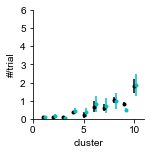

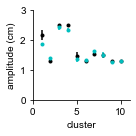

In [95]:
#monoc opto
cond = 'sutureopto'
df_cond = df_all[(df_all['condition']==cond)&(df_all['expt_group']=='ChR2')&(df_all['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
labels_cond = labels_all[(labels_all['condition']==cond)&(labels_all['expt_group']=='ChR2')&(labels_all['success']!=2)]
labels_all.reset_index(inplace=True,drop=True)

fig, axs = plt.subplots(1,1,figsize=(2,2))
axs, freq = am.plot_cluster_freq(axs,df_cond,labels_cond,'hclusters','laser_trial',0,6,plot_params['laser_col'],save_pdf,pp)

n_clust = freq.shape[2]
num_ani = freq.shape[1]
anova_df = pd.DataFrame(columns=['cluster','condition','frequency'])

for clust in range(n_clust):
    temp_df = pd.DataFrame(columns=['cluster','condition','frequency'])
    temp_df['cluster'] = np.ones(num_ani*2)*clust
    temp_df['condition'] = np.hstack((np.zeros(num_ani),np.ones(num_ani))).astype(int)
    temp_df['frequency'] = np.hstack((freq[0,:,clust],freq[1,:,clust]))

    anova_df = pd.concat([anova_df,temp_df])

model = ols('frequency ~ C(cluster) + C(condition) + C(cluster):C(condition)', data=anova_df).fit()
print('anova frequency as a function of cluster and condition')
print(sm.stats.anova_lm(model, typ=2))


fig, axs, amps = am.plot_cluster_amplitudes(labels_cond,'hclusters','laser_trial',0,3,plot_params['laser_col'],save_pdf,pp)

n_clust = amps.shape[2]
num_ani = amps.shape[0]
anova_df = pd.DataFrame(columns=['cluster','condition','amps'])

for clust in range(n_clust):
    temp_df = pd.DataFrame(columns=['cluster','condition','amps'])
    temp_df['cluster'] = np.ones(num_ani*2)*clust
    temp_df['condition'] = np.hstack((np.zeros(num_ani),np.ones(num_ani))).astype(int)
    temp_df['amps'] = np.hstack((amps[:,0,clust],amps[:,1,clust]))

    anova_df = pd.concat([anova_df,temp_df])

model = ols('amps ~ C(cluster) + C(condition) + C(cluster):C(condition)', data=anova_df).fit()
print('anova amps as a function of cluster and condition')
print(sm.stats.anova_lm(model, typ=2))

cluster 1 p=0.250
cluster 2 p=0.375
cluster 3 p=0.625
cluster 4 p=0.875
cluster 5 p=0.125
cluster 6 p=0.250
cluster 7 p=0.875
cluster 8 p=0.625
cluster 9 p=0.875
cluster 10 p=0.625
anova frequency as a function of cluster and condition
                             sum_sq    df          F        PR(>F)
C(cluster)               116.055396   9.0  20.282866  3.967364e-15
C(condition)               0.327014   1.0   0.514366  4.760376e-01
C(cluster):C(condition)    1.207534   9.0   0.211039  9.918241e-01
Residual                  38.145627  60.0        NaN           NaN
binoc vs. monoc amp cluster 1 p=nan
binoc vs. monoc amp cluster 2 p=0.95
binoc vs. monoc amp cluster 3 p=0.02
binoc vs. monoc amp cluster 4 p=0.60
binoc vs. monoc amp cluster 5 p=0.96
binoc vs. monoc amp cluster 6 p=0.18
binoc vs. monoc amp cluster 7 p=0.90
binoc vs. monoc amp cluster 8 p=0.75
binoc vs. monoc amp cluster 9 p=0.37
binoc vs. monoc amp cluster 10 p=0.80
anova amps as a function of cluster and condition
         

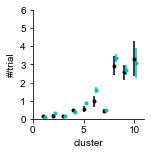

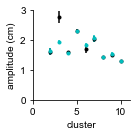

In [96]:
df_all = pd.read_hdf(r'T:\variable_platform_mvmnts_250ms_velocity_df.h5')
labels_all = pd.read_hdf(r'T:\variable_platform_mvmnts_250ms_velocity_labels.h5')

expt_group = []
for index,row in df_all.iterrows():
    if 'PV' in str(row['subject']):
        expt_group.append('ChR2')
    else:
        expt_group.append('WT')
df_all['expt_group'] = expt_group

expt_group = []
for index,row in labels_all.iterrows():
    if 'PV' in str(row['subject']):
        expt_group.append('ChR2')
    else:
        expt_group.append('WT')
labels_all['expt_group'] = expt_group

labels_all = am.get_movement_amplitudes_mm(labels_all,'Side')

#monoc/monoc opto
cond = 'opto suture'
df_cond = df_all[(df_all['condition']==cond)&(df_all['expt_group']=='ChR2')&(df_all['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
labels_cond = labels_all[(labels_all['condition']==cond)&(labels_all['expt_group']=='ChR2')&(labels_all['success']!=2)]
labels_all.reset_index(inplace=True,drop=True)

fig, axs = plt.subplots(1,1,figsize=(2,2))
axs, freq = am.plot_cluster_freq(axs,df_cond,labels_cond,'hclusters','laser_trial',0,6,plot_params['laser_col'],save_pdf,pp)

n_clust = freq.shape[2]
num_ani = freq.shape[1]
anova_df = pd.DataFrame(columns=['cluster','condition','frequency'])

for clust in range(n_clust):
    temp_df = pd.DataFrame(columns=['cluster','condition','frequency'])
    temp_df['cluster'] = np.ones(num_ani*2)*clust
    temp_df['condition'] = np.hstack((np.zeros(num_ani),np.ones(num_ani))).astype(int)
    temp_df['frequency'] = np.hstack((freq[0,:,clust],freq[1,:,clust]))

    anova_df = pd.concat([anova_df,temp_df])

model = ols('frequency ~ C(cluster) + C(condition) + C(cluster):C(condition)', data=anova_df).fit()
print('anova frequency as a function of cluster and condition')
print(sm.stats.anova_lm(model, typ=2))


fig, axs, amps = am.plot_cluster_amplitudes(labels_cond,'hclusters','laser_trial',0,3,plot_params['laser_col'],save_pdf,pp)

n_clust = amps.shape[2]
num_ani = amps.shape[0]
anova_df = pd.DataFrame(columns=['cluster','condition','amps'])

for clust in range(n_clust):
    temp_df = pd.DataFrame(columns=['cluster','condition','amps'])
    temp_df['cluster'] = np.ones(num_ani*2)*clust
    temp_df['condition'] = np.hstack((np.zeros(num_ani),np.ones(num_ani))).astype(int)
    temp_df['amps'] = np.hstack((amps[:,0,clust],amps[:,1,clust]))

    anova_df = pd.concat([anova_df,temp_df])

model = ols('amps ~ C(cluster) + C(condition) + C(cluster):C(condition)', data=anova_df).fit()
print('anova amps as a function of cluster and condition')
print(sm.stats.anova_lm(model, typ=2))

### plot opto changes in head position

In [21]:
# ### load revision side data
# data_file = r'T:\jumping_revisions_analysis\df_decision_alldata_Side.h5'
# df_side_revision = pd.read_hdf(data_file,key='df')

# df_side_revision = am.calculate_pitch(df_side_revision)

0 -19.68+/-3.65, 1 -28.04+/-2.63, laser_trial Side_pitch_mean t-test p=0.125
0 -25.35+/-5.47, 1 -24.22+/-4.83, laser_trial Side_pitch_mean t-test p=0.625
controlopto Side_pitch_mean unpaired t-test p=0.004
0 -25.15+/-1.25, 1 -28.94+/-1.92, laser_trial Side_pitch_mean t-test p=0.125
0 -29.83+/-5.92, 1 -29.97+/-6.20, laser_trial Side_pitch_mean t-test p=0.875
sutureopto Side_pitch_mean unpaired t-test p=0.153
laser off -43.41+/-0.80, laser on -45.87+/-0.75, laser_trial Side_pitch_mean t-test p=0.125
laser off -41.20+/-1.29, laser on -40.47+/-1.32, laser_trial Side_pitch_mean t-test p=0.250
opto suture Side_pitch_mean unpaired t-test p=0.002
0 22.72+/-3.65, 1 15.87+/-3.14, laser_trial Top_yaw_mn t-test p=0.125
0 13.74+/-3.42, 1 12.81+/-2.51, laser_trial Top_yaw_mn t-test p=0.875
controlopto Top_yaw_mn unpaired t-test p=0.116
0 18.78+/-3.86, 1 18.47+/-2.90, laser_trial Top_yaw_mn t-test p=1.000
0 15.88+/-4.87, 1 16.09+/-3.37, laser_trial Top_yaw_mn t-test p=0.875
sutureopto Top_yaw_mn unpa

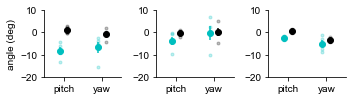

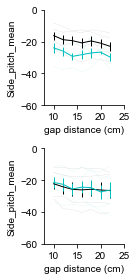

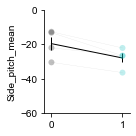

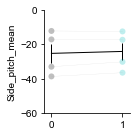

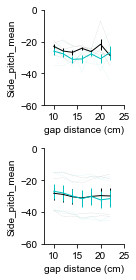

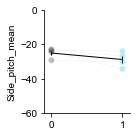

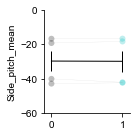

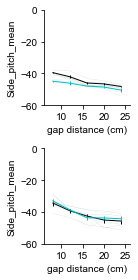

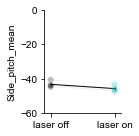

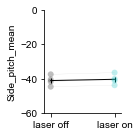

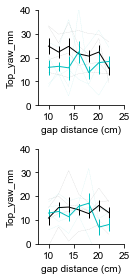

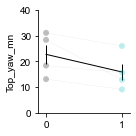

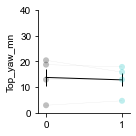

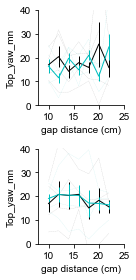

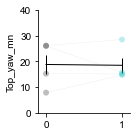

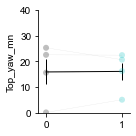

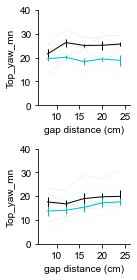

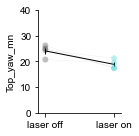

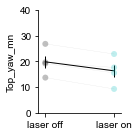

In [76]:
### plot pitch
 
variable = 'Side_pitch_mean'
condition = 'laser_trial'

jfig, jax = plt.subplots(1,3,figsize=(5,1.5))
xvals = [0.9,1.1]
cols = ['c','k']

cond = 'controlopto'
df_cond = df_pitch[(df_pitch['condition']==cond)&(df_pitch['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
fig, axs = plt.subplots(2,1,figsize=(2,4))
axs = am.plot_variable_vs_distance_manipulation(axs,df_cond,variable,'expt_group','laser_trial',8,24,-60,0,plot_params['laser_col'],save_pdf,pp,suptitle='')
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

ttest_data = np.zeros((4,2))
ax = jax[0]
for g,grp in enumerate(np.unique(df_cond['expt_group'])):
    fig, axs, p, d_pitch = am.plot_variable_condition(df_cond[df_cond['expt_group']==grp],condition,variable,0.9,2.1,-60,0,plot_params['laser_col'],save_pdf,pp)
    ax.plot([xvals[g]]*4,(d_pitch[:,1]-d_pitch[:,0]),ls='none',marker='o',color=cols[g],markersize=3,alpha=0.25)
    ax.errorbar(x=xvals[g],y=np.mean(d_pitch[:,1]-d_pitch[:,0]),yerr=np.std(d_pitch[:,1]-d_pitch[:,0])/np.sqrt(4),ls='none',marker='o',color=cols[g])
    ttest_data[:,g] = d_pitch[:,1]-d_pitch[:,0]
s,p = stats.ttest_ind(ttest_data[:,0],ttest_data[:,1])
print('%s %s unpaired t-test p=%0.3f' % (cond,variable,p))


cond = 'sutureopto'
df_cond = df_pitch[(df_pitch['condition']==cond)&(df_pitch['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
fig, axs = plt.subplots(2,1,figsize=(2,4))
axs = am.plot_variable_vs_distance_manipulation(axs,df_cond,variable,'expt_group','laser_trial',8,24,-60,0,plot_params['laser_col'],save_pdf,pp,suptitle='')
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

ttest_data = np.zeros((4,2))
ax = jax[1]
for g,grp in enumerate(np.unique(df_cond['expt_group'])):
    fig, axs, p, d_pitch = am.plot_variable_condition(df_cond[df_cond['expt_group']==grp],condition,variable,0.9,2.1,-60,0,plot_params['laser_col'],save_pdf,pp)
    ax.plot([xvals[g]]*4,(d_pitch[:,1]-d_pitch[:,0]),ls='none',marker='o',color=cols[g],markersize=3,alpha=0.25)
    ax.errorbar(x=xvals[g],y=np.mean(d_pitch[:,1]-d_pitch[:,0]),yerr=np.std(d_pitch[:,1]-d_pitch[:,0])/np.sqrt(4),ls='none',marker='o',color=cols[g])
    ttest_data[:,g] = d_pitch[:,1]-d_pitch[:,0]
s,p = stats.ttest_ind(ttest_data[:,0],ttest_data[:,1])
print('%s %s unpaired t-test p=%0.3f' % (cond,variable,p))


mvmnt_file = r'T:\jumping_revisions_analysis\df_corrected_pitch_og.h5'
df_side_og = pd.read_hdf(mvmnt_file,key='df')
variable = 'Side_pitch_mean'
cond = 'opto suture'
df_cond = df_side_og[(df_side_og['condition']==cond)&(df_side_og['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
fig, axs = plt.subplots(2,1,figsize=(2,4))
axs = am.plot_variable_vs_distance_manipulation(axs,df_cond,variable,'expt_group','laser_trial',6,26,-60,0,plot_params['laser_col'],save_pdf,pp,suptitle='')
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

ttest_data = np.zeros((4,2))
ax = jax[2]
for g,grp in enumerate(np.unique(df_cond['expt_group'])):
    fig, axs, p, d_pitch = am.plot_variable_condition(df_cond[df_cond['expt_group']==grp],condition,variable,0.9,2.1,-60,0,plot_params['laser_col'],save_pdf,pp)
    ax.plot([xvals[g]]*4,(d_pitch[:,1]-d_pitch[:,0]),ls='none',marker='o',color=cols[g],markersize=3,alpha=0.25)
    ax.errorbar(x=xvals[g],y=np.mean(d_pitch[:,1]-d_pitch[:,0]),yerr=np.std(d_pitch[:,1]-d_pitch[:,0])/np.sqrt(4),ls='none',marker='o',color=cols[g])
    ttest_data[:,g] = d_pitch[:,1]-d_pitch[:,0]
s,p = stats.ttest_ind(ttest_data[:,0],ttest_data[:,1])
print('%s %s unpaired t-test p=%0.3f' % (cond,variable,p))

### revision group yaw
yaw_revision = pd.read_hdf(r'T:\jumping_revisions_analysis\yaw_revision_df.h5',key='df')
variable = 'Top_yaw_mn'
condition = 'laser_trial'

cond = 'controlopto'
df_cond = yaw_revision[(yaw_revision['condition']==cond)&(yaw_revision['success']==1)]
df_cond.reset_index(inplace=True,drop=True)
fig, axs = plt.subplots(2,1,figsize=(2,4))
ax = am.plot_variable_vs_distance_manipulation(axs,df_cond,variable,'expt_group','laser_trial',8,24,0,40,plot_params['laser_col'],save_pdf,pp,suptitle='')
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)


### plot yaw
xvals = [1.9,2.1]

ttest_data = np.zeros((4,2))
ax = jax[0]
for g,grp in enumerate(np.unique(df_cond['expt_group'])):
    fig, axs, p, d_pitch = am.plot_variable_condition(df_cond[df_cond['expt_group']==grp],condition,variable,0.9,2.1,0,40,plot_params['laser_col'],save_pdf,pp)
    ax.plot([xvals[g]]*4,(d_pitch[:,1]-d_pitch[:,0]),ls='none',marker='o',color=cols[g],markersize=3,alpha=0.25)
    ax.errorbar(x=xvals[g],y=np.mean(d_pitch[:,1]-d_pitch[:,0]),yerr=np.std(d_pitch[:,1]-d_pitch[:,0])/np.sqrt(4),ls='none',marker='o',color=cols[g])
    ttest_data[:,g] = d_pitch[:,1]-d_pitch[:,0]
s,p = stats.ttest_ind(ttest_data[:,0],ttest_data[:,1])
print('%s %s unpaired t-test p=%0.3f' % (cond,variable,p))

ax.set_xticks([1,2])
ax.set_xticklabels(['pitch','yaw'])
ax.axis([0.5,2.5,-20,10])
ax.set_yticks(np.arange(-20,20,10))
ax.set_ylabel('angle (deg)')
ax = am.xy_axis(ax)

cond = 'sutureopto'
df_cond = yaw_revision[(yaw_revision['condition']==cond)&(yaw_revision['success']==1)]
df_cond.reset_index(inplace=True,drop=True)
fig, axs = plt.subplots(2,1,figsize=(2,4))
ax = am.plot_variable_vs_distance_manipulation(axs,df_cond,variable,'expt_group','laser_trial',8,24,0,40,plot_params['laser_col'],save_pdf,pp,suptitle='')
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

ttest_data = np.zeros((4,2))
ax = jax[1]
for g,grp in enumerate(np.unique(df_cond['expt_group'])):
    fig, axs, p, d_pitch = am.plot_variable_condition(df_cond[df_cond['expt_group']==grp],condition,variable,0.9,2.1,0,40,plot_params['laser_col'],save_pdf,pp)
    ax.plot([xvals[g]]*4,(d_pitch[:,1]-d_pitch[:,0]),ls='none',marker='o',color=cols[g],markersize=3,alpha=0.25)
    ax.errorbar(x=xvals[g],y=np.mean(d_pitch[:,1]-d_pitch[:,0]),yerr=np.std(d_pitch[:,1]-d_pitch[:,0])/np.sqrt(4),ls='none',marker='o',color=cols[g])
    ttest_data[:,g] = d_pitch[:,1]-d_pitch[:,0]
s,p = stats.ttest_ind(ttest_data[:,0],ttest_data[:,1])
print('%s %s unpaired t-test p=%0.3f' % (cond,variable,p))

ax.set_xticks([1,2])
ax.set_xticklabels(['pitch','yaw'])
ax.axis([0.5,2.5,-20,10])
ax.set_yticks(np.arange(-20,20,10))
ax = am.xy_axis(ax)

yaw_og = pd.read_hdf(r'T:\jumping_revisions_analysis\yaw_og_df.h5',key='df')

cond = 'opto suture'

df_cond = yaw_og[(yaw_og['condition']==cond)&(yaw_og['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
fig, axs = plt.subplots(2,1,figsize=(2,4))
ax = am.plot_variable_vs_distance_manipulation(axs,df_cond,variable,'expt_group','laser_trial',6,26,0,40,plot_params['laser_col'],save_pdf,pp,suptitle='')
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

ttest_data = np.zeros((4,2))
ax = jax[2]
for g,grp in enumerate(np.unique(df_cond['expt_group'])):
    fig, axs, p, d_pitch = am.plot_variable_condition(df_cond[df_cond['expt_group']==grp],condition,variable,0.9,2.1,0,40,plot_params['laser_col'],save_pdf,pp)
    ax.plot([xvals[g]]*4,(d_pitch[:,1]-d_pitch[:,0]),ls='none',marker='o',color=cols[g],markersize=3,alpha=0.25)
    ax.errorbar(x=xvals[g],y=np.mean(d_pitch[:,1]-d_pitch[:,0]),yerr=np.std(d_pitch[:,1]-d_pitch[:,0])/np.sqrt(4),ls='none',marker='o',color=cols[g])
    ttest_data[:,g] = d_pitch[:,1]-d_pitch[:,0]
s,p = stats.ttest_ind(ttest_data[:,0],ttest_data[:,1])
print('%s %s unpaired t-test p=%0.3f' % (cond,variable,p))

ax.set_xticks([1,2])
ax.set_xticklabels(['pitch','yaw'])
ax.axis([0.5,2.5,-20,10])
ax.set_yticks(np.arange(-20,20,10))
ax = am.xy_axis(ax)

jfig.tight_layout()
if save_pdf:
    pp.savefig(jfig)


0 16.33+/-1.34, 1 18.36+/-0.96, laser_trial Side_pitch_std t-test p=0.112
0 16.78+/-0.65, 1 17.57+/-0.92, laser_trial Side_pitch_std t-test p=0.160
controlopto Side_pitch_std unpaired t-test p=0.268
0 19.12+/-1.73, 1 20.53+/-2.06, laser_trial Side_pitch_std t-test p=0.165
0 16.88+/-0.25, 1 16.72+/-0.54, laser_trial Side_pitch_std t-test p=0.700
sutureopto Side_pitch_std unpaired t-test p=0.117
laser off 15.30+/-0.66, laser on 16.45+/-1.84, laser_trial Side_pitch_std t-test p=0.543
laser off 14.66+/-2.24, laser on 14.54+/-2.46, laser_trial Side_pitch_std t-test p=0.722
opto suture Side_pitch_std unpaired t-test p=0.486
0 10.87+/-2.39, 1 20.47+/-5.30, laser_trial Top_yaw_std t-test p=0.103
0 9.88+/-1.53, 1 12.36+/-2.72, laser_trial Top_yaw_std t-test p=0.248
controlopto Top_yaw_std unpaired t-test p=0.164
0 20.80+/-5.71, 1 23.14+/-6.26, laser_trial Top_yaw_std t-test p=0.177
0 13.25+/-3.38, 1 16.44+/-6.78, laser_trial Top_yaw_std t-test p=0.489
sutureopto Top_yaw_std unpaired t-test p=0.

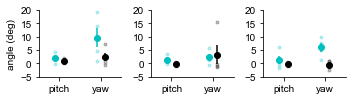

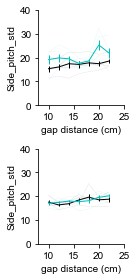

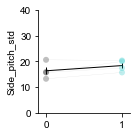

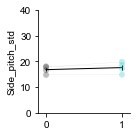

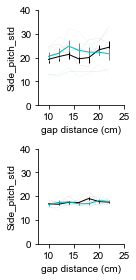

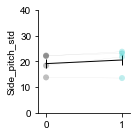

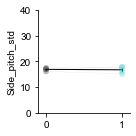

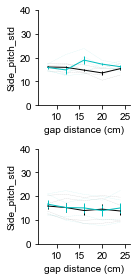

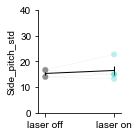

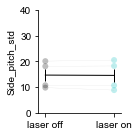

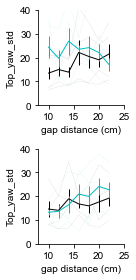

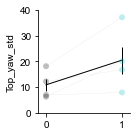

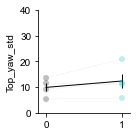

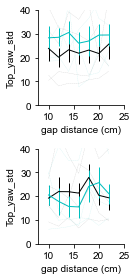

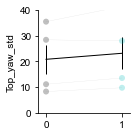

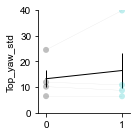

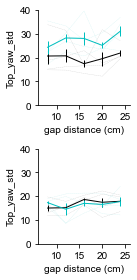

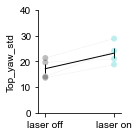

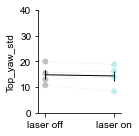

In [343]:
### plot pitch
 
variable = 'Side_pitch_std'
condition = 'laser_trial'

jfig, jax = plt.subplots(1,3,figsize=(5,1.5))
xvals = [0.9,1.1]
cols = ['c','k']

cond = 'controlopto'
df_cond = df_pitch[(df_pitch['condition']==cond)&(df_pitch['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
fig, axs = plt.subplots(2,1,figsize=(2,4))
axs = am.plot_variable_vs_distance_manipulation(axs,df_cond,variable,'expt_group','laser_trial',8,24,0,40,plot_params['laser_col'],save_pdf,pp,suptitle='')
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

ttest_data = np.zeros((4,2))
ax = jax[0]
for g,grp in enumerate(np.unique(df_cond['expt_group'])):
    fig, axs, p, d_pitch = am.plot_variable_condition(df_cond[df_cond['expt_group']==grp],condition,variable,0.9,2.1,0,40,plot_params['laser_col'],save_pdf,pp)
    ax.plot([xvals[g]]*4,(d_pitch[:,1]-d_pitch[:,0]),ls='none',marker='o',color=cols[g],markersize=3,alpha=0.25)
    ax.errorbar(x=xvals[g],y=np.mean(d_pitch[:,1]-d_pitch[:,0]),yerr=np.std(d_pitch[:,1]-d_pitch[:,0])/np.sqrt(4),ls='none',marker='o',color=cols[g])
    ttest_data[:,g] = d_pitch[:,1]-d_pitch[:,0]
s,p = stats.ttest_ind(ttest_data[:,0],ttest_data[:,1])
print('%s %s unpaired t-test p=%0.3f' % (cond,variable,p))


cond = 'sutureopto'
df_cond = df_pitch[(df_pitch['condition']==cond)&(df_pitch['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
fig, axs = plt.subplots(2,1,figsize=(2,4))
axs = am.plot_variable_vs_distance_manipulation(axs,df_cond,variable,'expt_group','laser_trial',8,24,0,40,plot_params['laser_col'],save_pdf,pp,suptitle='')
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

ttest_data = np.zeros((4,2))
ax = jax[1]
for g,grp in enumerate(np.unique(df_cond['expt_group'])):
    fig, axs, p, d_pitch = am.plot_variable_condition(df_cond[df_cond['expt_group']==grp],condition,variable,0.9,2.1,0,40,plot_params['laser_col'],save_pdf,pp)
    ax.plot([xvals[g]]*4,(d_pitch[:,1]-d_pitch[:,0]),ls='none',marker='o',color=cols[g],markersize=3,alpha=0.25)
    ax.errorbar(x=xvals[g],y=np.mean(d_pitch[:,1]-d_pitch[:,0]),yerr=np.std(d_pitch[:,1]-d_pitch[:,0])/np.sqrt(4),ls='none',marker='o',color=cols[g])
    ttest_data[:,g] = d_pitch[:,1]-d_pitch[:,0]
s,p = stats.ttest_ind(ttest_data[:,0],ttest_data[:,1])
print('%s %s unpaired t-test p=%0.3f' % (cond,variable,p))


mvmnt_file = r'T:\jumping_revisions_analysis\df_corrected_pitch_og.h5'
df_side_og = pd.read_hdf(mvmnt_file,key='df')
cond = 'opto suture'
df_cond = df_side_og[(df_side_og['condition']==cond)&(df_side_og['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
fig, axs = plt.subplots(2,1,figsize=(2,4))
axs = am.plot_variable_vs_distance_manipulation(axs,df_cond,variable,'expt_group','laser_trial',6,26,0,40,plot_params['laser_col'],save_pdf,pp,suptitle='')
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

ttest_data = np.zeros((4,2))
ax = jax[2]
for g,grp in enumerate(np.unique(df_cond['expt_group'])):
    fig, axs, p, d_pitch = am.plot_variable_condition(df_cond[df_cond['expt_group']==grp],condition,variable,0.9,2.1,0,40,plot_params['laser_col'],save_pdf,pp)
    ax.plot([xvals[g]]*4,(d_pitch[:,1]-d_pitch[:,0]),ls='none',marker='o',color=cols[g],markersize=3,alpha=0.25)
    ax.errorbar(x=xvals[g],y=np.mean(d_pitch[:,1]-d_pitch[:,0]),yerr=np.std(d_pitch[:,1]-d_pitch[:,0])/np.sqrt(4),ls='none',marker='o',color=cols[g])
    ttest_data[:,g] = d_pitch[:,1]-d_pitch[:,0]
s,p = stats.ttest_ind(ttest_data[:,0],ttest_data[:,1])
print('%s %s unpaired t-test p=%0.3f' % (cond,variable,p))

### revision group yaw
yaw_revision = pd.read_hdf(r'T:\jumping_revisions_analysis\yaw_revision_df.h5',key='df')
variable = 'Top_yaw_std'
condition = 'laser_trial'

cond = 'controlopto'
df_cond = yaw_revision[(yaw_revision['condition']==cond)&(yaw_revision['success']==1)]
df_cond.reset_index(inplace=True,drop=True)
fig, axs = plt.subplots(2,1,figsize=(2,4))
ax = am.plot_variable_vs_distance_manipulation(axs,df_cond,variable,'expt_group','laser_trial',8,24,0,40,plot_params['laser_col'],save_pdf,pp,suptitle='')
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)


### plot yaw
xvals = [1.9,2.1]

ttest_data = np.zeros((4,2))
ax = jax[0]
for g,grp in enumerate(np.unique(df_cond['expt_group'])):
    fig, axs, p, d_pitch = am.plot_variable_condition(df_cond[df_cond['expt_group']==grp],condition,variable,0.9,2.1,0,40,plot_params['laser_col'],save_pdf,pp)
    ax.plot([xvals[g]]*4,(d_pitch[:,1]-d_pitch[:,0]),ls='none',marker='o',color=cols[g],markersize=3,alpha=0.25)
    ax.errorbar(x=xvals[g],y=np.mean(d_pitch[:,1]-d_pitch[:,0]),yerr=np.std(d_pitch[:,1]-d_pitch[:,0])/np.sqrt(4),ls='none',marker='o',color=cols[g])
    ttest_data[:,g] = d_pitch[:,1]-d_pitch[:,0]
s,p = stats.ttest_ind(ttest_data[:,0],ttest_data[:,1])
print('%s %s unpaired t-test p=%0.3f' % (cond,variable,p))

ax.set_xticks([1,2])
ax.set_xticklabels(['pitch','yaw'])
ax.axis([0.5,2.5,-5,20])
ax.set_yticks(np.arange(-5,25,5))
ax.set_ylabel('angle (deg)')
ax = am.xy_axis(ax)

cond = 'sutureopto'
df_cond = yaw_revision[(yaw_revision['condition']==cond)&(yaw_revision['success']==1)]
df_cond.reset_index(inplace=True,drop=True)
fig, axs = plt.subplots(2,1,figsize=(2,4))
ax = am.plot_variable_vs_distance_manipulation(axs,df_cond,variable,'expt_group','laser_trial',8,24,0,40,plot_params['laser_col'],save_pdf,pp,suptitle='')
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

ttest_data = np.zeros((4,2))
ax = jax[1]
for g,grp in enumerate(np.unique(df_cond['expt_group'])):
    fig, axs, p, d_pitch = am.plot_variable_condition(df_cond[df_cond['expt_group']==grp],condition,variable,0.9,2.1,0,40,plot_params['laser_col'],save_pdf,pp)
    ax.plot([xvals[g]]*4,(d_pitch[:,1]-d_pitch[:,0]),ls='none',marker='o',color=cols[g],markersize=3,alpha=0.25)
    ax.errorbar(x=xvals[g],y=np.mean(d_pitch[:,1]-d_pitch[:,0]),yerr=np.std(d_pitch[:,1]-d_pitch[:,0])/np.sqrt(4),ls='none',marker='o',color=cols[g])
    ttest_data[:,g] = d_pitch[:,1]-d_pitch[:,0]
s,p = stats.ttest_ind(ttest_data[:,0],ttest_data[:,1])
print('%s %s unpaired t-test p=%0.3f' % (cond,variable,p))

ax.set_xticks([1,2])
ax.set_xticklabels(['pitch','yaw'])
ax.axis([0.5,2.5,-5,20])
ax.set_yticks(np.arange(-5,25,5))
ax = am.xy_axis(ax)

yaw_og = pd.read_hdf(r'T:\jumping_revisions_analysis\yaw_og_df.h5',key='df')

cond = 'opto suture'

df_cond = yaw_og[(yaw_og['condition']==cond)&(yaw_og['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
fig, axs = plt.subplots(2,1,figsize=(2,4))
ax = am.plot_variable_vs_distance_manipulation(axs,df_cond,variable,'expt_group','laser_trial',6,26,0,40,plot_params['laser_col'],save_pdf,pp,suptitle='')
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

ttest_data = np.zeros((4,2))
ax = jax[2]
for g,grp in enumerate(np.unique(df_cond['expt_group'])):
    fig, axs, p, d_pitch = am.plot_variable_condition(df_cond[df_cond['expt_group']==grp],condition,variable,0.9,2.1,0,40,plot_params['laser_col'],save_pdf,pp)
    ax.plot([xvals[g]]*4,(d_pitch[:,1]-d_pitch[:,0]),ls='none',marker='o',color=cols[g],markersize=3,alpha=0.25)
    ax.errorbar(x=xvals[g],y=np.mean(d_pitch[:,1]-d_pitch[:,0]),yerr=np.std(d_pitch[:,1]-d_pitch[:,0])/np.sqrt(4),ls='none',marker='o',color=cols[g])
    ttest_data[:,g] = d_pitch[:,1]-d_pitch[:,0]
s,p = stats.ttest_ind(ttest_data[:,0],ttest_data[:,1])
print('%s %s unpaired t-test p=%0.3f' % (cond,variable,p))

ax.set_xticks([1,2])
ax.set_xticklabels(['pitch','yaw'])
ax.axis([0.5,2.5,-5,20])
ax.set_yticks(np.arange(-5,25,5))
ax = am.xy_axis(ax)

jfig.tight_layout()
if save_pdf:
    pp.savefig(jfig)


In [295]:
pp.close()

In [276]:
# # monoc vis/monoc zone v1
# # mvmnt_file = r'T:\variable_platform_allpts.h5'
# # df_side_og = pd.read_hdf(mvmnt_file,key='df')
# # df_side_og['distance_DLC'] = df_side_og['distance']
# # df_side_og['platform_DLC'] = df_side_og['platform']

# # expt_group = []
# # for index,row in df_side_og.iterrows():
# #     if 'PV' in str(row['subject']):
# #         expt_group.append('ChR2')
# #     else:
# #         expt_group.append('WT')
# # df_side_og['expt_group'] = expt_group

# # df_side_og = am.calculate_pitch_og(df_side_og,r'D:\Phil\jumping_analysis\paper_cohort\clipped_vids')

# # df_side_og.to_hdf(r'T:\jumping_revisions_analysis\df_corrected_pitch_og.h5',key='df',mode='w')

# mvmnt_file = r'T:\jumping_revisions_analysis\df_corrected_pitch_og.h5'
# df_side_og = pd.read_hdf(mvmnt_file,key='df')

In [288]:
# variable = 'Side_pitch_mean'
# cond = 'opto suture'
# df_cond = df_side_og[(df_side_og['condition']==cond)&(df_side_og['success']!=2)]
# df_cond.reset_index(inplace=True,drop=True)
# fig, axs = plt.subplots(2,1,figsize=(2,4))
# axs = am.plot_variable_vs_distance_manipulation(axs,df_cond,variable,'expt_group','laser_trial',6,26,-60,0,plot_params['laser_col'],save_pdf,pp,suptitle='')
# fig.tight_layout()
# if save_pdf:
#     pp.savefig(fig)
#     plt.close(fig)

# for grp in np.unique(df_cond['expt_group']):
#     fig, axs, p, d_var = am.plot_variable_condition(df_cond[df_cond['expt_group']==grp],condition,variable,0.9,2.1,-60,0,plot_params['laser_col'],save_pdf,pp)

laser off -43.41+/-0.80, laser on -45.87+/-0.75, laser_trial Side_pitch_mean t-test p=0.010
laser off -41.20+/-1.29, laser on -40.47+/-1.32, laser_trial Side_pitch_mean t-test p=0.197


### opto yaw

In [338]:
### calculate yaw
# df_jump_revision = am.calculate_yaw(df_jump_revision,r'T:\jumping_revisions')
# df_jump_og = am.calculate_yaw_og(df_jump_og,r'D:\Phil\jumping_analysis\paper_cohort\clipped_vids')

doing 0 of 4310
doing 500 of 4310
doing 1000 of 4310
doing 1500 of 4310
doing 2000 of 4310
doing 2500 of 4310
doing 3000 of 4310
doing 3500 of 4310
doing 4000 of 4310


In [339]:
# df_jump_revision.to_hdf(r'T:\jumping_revisions_analysis\yaw_revision_df.h5',key='df',mode='w')
# df_jump_og.to_hdf(r'T:\jumping_revisions_analysis\yaw_og_df.h5',key='df',mode='w')

0 10.87+/-2.39, 1 20.47+/-5.30, laser_trial Top_yaw_std t-test p=0.103
0 9.88+/-1.53, 1 12.36+/-2.72, laser_trial Top_yaw_std t-test p=0.248
0 20.80+/-5.71, 1 23.14+/-6.26, laser_trial Top_yaw_std t-test p=0.177
0 13.25+/-3.38, 1 16.44+/-6.78, laser_trial Top_yaw_std t-test p=0.489
laser off 17.16+/-1.68, laser on 23.18+/-1.89, laser_trial Top_yaw_std t-test p=0.046
laser off 14.78+/-1.71, laser on 14.34+/-1.93, laser_trial Top_yaw_std t-test p=0.625


'WT'

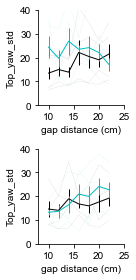

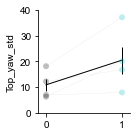

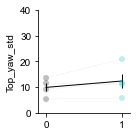

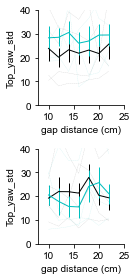

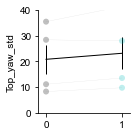

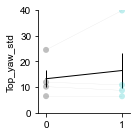

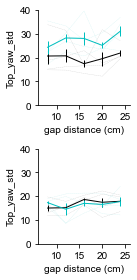

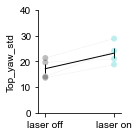

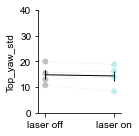

In [234]:
# ### revision group yaw
# yaw_revision = pd.read_hdf(r'T:\jumping_revisions_analysis\yaw_revision_df.h5',key='df')
# variable = 'Top_yaw_std'
# condition = 'laser_trial'

# cond = 'controlopto'
# df_cond = yaw_revision[(yaw_revision['condition']==cond)&(yaw_revision['success']==1)]
# df_cond.reset_index(inplace=True,drop=True)
# fig, axs = plt.subplots(2,1,figsize=(2,4))
# ax = am.plot_variable_vs_distance_manipulation(axs,df_cond,variable,'expt_group','laser_trial',8,24,0,40,plot_params['laser_col'],save_pdf,pp,suptitle='')
# fig.tight_layout()
# if save_pdf:
#     pp.savefig(fig)
#     plt.close(fig)

# for grp in np.unique(df_cond['expt_group']):
#     fig, axs, p, d_yaw = am.plot_variable_condition(df_cond[df_cond['expt_group']==grp],condition,variable,0.9,2.1,0,40,plot_params['laser_col'],save_pdf,pp)

# cond = 'sutureopto'
# df_cond = yaw_revision[(yaw_revision['condition']==cond)&(yaw_revision['success']==1)]
# df_cond.reset_index(inplace=True,drop=True)
# fig, axs = plt.subplots(2,1,figsize=(2,4))
# ax = am.plot_variable_vs_distance_manipulation(axs,df_cond,variable,'expt_group','laser_trial',8,24,0,40,plot_params['laser_col'],save_pdf,pp,suptitle='')
# fig.tight_layout()
# if save_pdf:
#     pp.savefig(fig)
#     plt.close(fig)

# for grp in np.unique(df_cond['expt_group']):
#     fig, axs, p, d_yaw = am.plot_variable_condition(df_cond[df_cond['expt_group']==grp],condition,variable,0.9,2.1,0,40,plot_params['laser_col'],save_pdf,pp)


# yaw_og = pd.read_hdf(r'T:\jumping_revisions_analysis\yaw_og_df.h5',key='df')

# cond = 'opto suture'
# condition = 'laser_trial'
# # variable = 'Top_yaw_std'

# df_cond = yaw_og[(yaw_og['condition']==cond)&(yaw_og['success']!=2)]
# df_cond.reset_index(inplace=True,drop=True)
# fig, axs = plt.subplots(2,1,figsize=(2,4))
# ax = am.plot_variable_vs_distance_manipulation(axs,df_cond,variable,'expt_group','laser_trial',6,26,0,40,plot_params['laser_col'],save_pdf,pp,suptitle='')
# fig.tight_layout()
# if save_pdf:
#     pp.savefig(fig)
#     plt.close(fig)

# for grp in np.unique(df_cond['expt_group']):
#     fig, axs, p, d_yaw = am.plot_variable_condition(df_cond[df_cond['expt_group']==grp],condition,variable,0.9,2.1,0,40,plot_params['laser_col'],save_pdf,pp)


### opto trial duration

0 21.68+/-1.54, 1 29.04+/-4.94, laser_trial mvmnt_integral t-test p=0.267
0 4.33+/-0.31, 1 5.78+/-1.43, laser_trial trial_duration t-test p=0.391
0 34.96+/-4.74, 1 34.46+/-9.30, laser_trial mvmnt_integral t-test p=0.942
0 7.69+/-1.51, 1 8.50+/-3.16, laser_trial trial_duration t-test p=0.712
laser off 32.78+/-6.70, laser on 44.02+/-8.33, laser_trial mvmnt_integral t-test p=0.143
laser off 5.00+/-1.03, laser on 7.12+/-1.23, laser_trial trial_duration t-test p=0.050


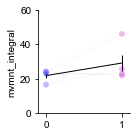

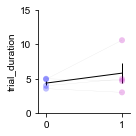

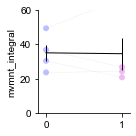

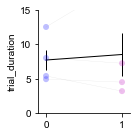

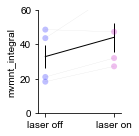

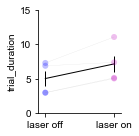

In [83]:
data_file = r'T:\jumping_revisions_analysis\df_corrected_pitch.h5'
df_pitch = pd.read_hdf(data_file,key='df')

cond = 'controlopto'
df_cond = df_pitch[(df_pitch['condition']==cond)&(df_pitch['success']!=2)&(df_pitch['expt_group']=='ChR2')]
df_cond.reset_index(inplace=True,drop=True)

mvmnt_integral = []
trial_duration = []
for index,row in df_cond.iterrows():
    x_int = np.sum(np.abs(np.diff(row['Side LEye x'][2:-2]/row['Side_pixpercm'])))
    y_int = np.sum(np.abs(np.diff(row['Side LEye y'][2:-2]/row['Side_pixpercm'])))
    tr_dur = len(row['Side LEye x'][2:-2])/row['fps']
    mvmnt_integral.append(x_int+y_int)
    trial_duration.append(tr_dur)
df_cond['mvmnt_integral'] = mvmnt_integral
df_cond['trial_duration'] = trial_duration


condition = 'laser_trial'
variable = 'mvmnt_integral'
fig, axs, p, d_var = am.plot_variable_condition(df_cond,condition,variable,0.9,2.1,0,60,plot_params['bm_col'],save_pdf,pp)
# axs.set_title('total movement distance')

variable = 'trial_duration'
fig, axs, p, d_var = am.plot_variable_condition(df_cond,condition,variable,0.9,2.1,0,15,plot_params['bm_col'],save_pdf,pp)


cond = 'sutureopto'
df_cond = df_pitch[(df_pitch['condition']==cond)&(df_pitch['success']!=2)&(df_pitch['expt_group']=='ChR2')]
df_cond.reset_index(inplace=True,drop=True)

mvmnt_integral = []
trial_duration = []
for index,row in df_cond.iterrows():
    x_int = np.sum(np.abs(np.diff(row['Side LEye x'][2:-2]/row['Side_pixpercm'])))
    y_int = np.sum(np.abs(np.diff(row['Side LEye y'][2:-2]/row['Side_pixpercm'])))
    tr_dur = len(row['Side LEye x'][2:-2])/row['fps']
    mvmnt_integral.append(x_int+y_int)
    trial_duration.append(tr_dur)
df_cond['mvmnt_integral'] = mvmnt_integral
df_cond['trial_duration'] = trial_duration


condition = 'laser_trial'
variable = 'mvmnt_integral'
fig, axs, p, d_var = am.plot_variable_condition(df_cond,condition,variable,0.9,2.1,0,60,plot_params['bm_col'],save_pdf,pp)
# axs.set_title('total movement distance')

variable = 'trial_duration'
fig, axs, p, d_var = am.plot_variable_condition(df_cond,condition,variable,0.9,2.1,0,15,plot_params['bm_col'],save_pdf,pp)


mvmnt_file = r'T:\jumping_revisions_analysis\df_corrected_pitch_og.h5'
df_pitch = pd.read_hdf(mvmnt_file,key='df')
cond = 'opto suture'

df_cond = df_pitch[(df_pitch['condition']==cond)&(df_pitch['success']!=2)&(df_pitch['expt_group']=='ChR2')]
df_cond.reset_index(inplace=True,drop=True)

mvmnt_integral = []
trial_duration = []
for index,row in df_cond.iterrows():
    x_int = np.sum(np.abs(np.diff(row['Side LEye x'][2:-2]/row['Side_pixpercm'])))
    y_int = np.sum(np.abs(np.diff(row['Side LEye y'][2:-2]/row['Side_pixpercm'])))
    tr_dur = len(row['Side LEye x'][2:-2])/row['fps']
    mvmnt_integral.append(x_int+y_int)
    trial_duration.append(tr_dur)
df_cond['mvmnt_integral'] = mvmnt_integral
df_cond['trial_duration'] = trial_duration


condition = 'laser_trial'
variable = 'mvmnt_integral'
fig, axs, p, d_var = am.plot_variable_condition(df_cond,condition,variable,0.9,2.1,0,60,plot_params['bm_col'],save_pdf,pp)
# axs.set_title('total movement distance')

variable = 'trial_duration'
fig, axs, p, d_var = am.plot_variable_condition(df_cond,condition,variable,0.9,2.1,0,15,plot_params['bm_col'],save_pdf,pp)

### plot changes in movement clusters

In [360]:
# ### this doesn't break things out by experimental group; supp figure does
# pwin = 0.25 #half the movement duration window desired
# # metric = 'position'
# metric = 'velocity'
# mvmnt_file = r'T:\jumping_revisions_analysis\variable_platform_mvmnts_%sms_%s.h5' % (int(pwin*1000),metric)
# df_pickle = mvmnt_file[:-3] + '_df.h5'
# labels_pickle = mvmnt_file[:-3] + '_labels.h5'
# df_all = pd.read_hdf(df_pickle,key='df')
# labels_all = pd.read_hdf(labels_pickle,key='df')
# print('%d hclusters %s' % (len(np.unique(labels_all['hclusters'])),metric))

# cluster_key = 'hclusters'
# side = 'Side'
# condition = 'laser_trial'

# cond = 'controlopto'
# base_df = df_all.copy()
# base_df = base_df[(base_df['condition']==cond)]
# base_df.reset_index(inplace=True,drop=True)
# base_labels = labels_all.copy()
# base_labels = base_labels[(base_labels['condition']==cond)]
# base_labels.reset_index(inplace=True,drop=True)

# fig, ax = am.plot_cluster_freq(base_df,base_labels,cluster_key,condition,plot_params['laser_col'],save_pdf,pp)


# cond = 'sutureopto'
# base_df = df_all.copy()
# base_df = base_df[(base_df['condition']==cond)]
# base_df.reset_index(inplace=True,drop=True)
# base_labels = labels_all.copy()
# base_labels = base_labels[(base_labels['condition']==cond)]
# base_labels.reset_index(inplace=True,drop=True)

# fig, ax = am.plot_cluster_freq(base_df,base_labels,cluster_key,condition,plot_params['laser_col'],save_pdf,pp)


# pwin = 0.25 #half the movement duration window desired
# # metric = 'position'
# metric = 'velocity'
# mvmnt_file = r'T:\variable_platform_mvmnts_%sms_%s.h5' % (int(pwin*1000),metric)
# df_pickle = mvmnt_file[:-3] + '_df.h5'
# labels_pickle = mvmnt_file[:-3] + '_labels.h5'
# df_all = pd.read_hdf(df_pickle,key='df')
# labels_all = pd.read_hdf(labels_pickle,key='df')
# print('%d hclusters %s' % (len(np.unique(labels_all['hclusters'])),metric))

# cond = 'opto suture'
# base_df = df_all.copy()
# base_df = base_df[(base_df['condition']==cond)]
# base_df.reset_index(inplace=True,drop=True)
# base_labels = labels_all.copy()
# base_labels = base_labels[(base_labels['condition']==cond)]
# base_labels.reset_index(inplace=True,drop=True)

# fig, ax = am.plot_cluster_freq(base_df,base_labels,cluster_key,condition,plot_params['laser_col'],save_pdf,pp)


10 hclusters velocity


# Supplemental figures

### Performance of every group broken out by failure, success, abort

In [12]:
pdf_file = r'G:\My Drive\Niell\Jumping paper\Manuscript\Resubmission\Figures\Supplemental\opto_performance_panels.pdf'
pp = PdfPages(pdf_file)
save_pdf = True

all subjects n=8
bi/mon fail/suc/abort anova p,F vals:  (array([0.96477813, 0.75155311, 0.60105287]), array([0.00195996, 0.10079501, 0.27519467]))
binoc vis/binoc V1 ChR2 n=4
bi/bi/ChR2 fail/suc/abort anova p,F vals:  (array([0.00770218, 0.00033539, 0.00198909]), array([ 7.83646919, 15.25237581, 10.87608027]))
binoc vis/binoc V1 WT n=4
bi/bi/WT fail/suc/abort anova p,F vals:  (array([0.86404884, 0.87185666, 0.79284751]), array([0.02967866, 0.02633767, 0.06985028]))
monoc vis/binoc V1 ChR2 n=4
mon/bi/ChR2 fail/suc/abort anova p,F vals:  (array([0.12980949, 0.53613255, 0.76574223]), array([2.38752557, 0.38912625, 0.08993249]))
monoc vis/binoc V1 WT n=4
mon/bi/WT fail/suc/abort anova p,F vals:  (array([0.08752719, 0.28075802, 0.84490147]), array([3.06038703, 1.19397158, 0.03874636]))
monoc vis/monoc V1 ChR2 n=4
mon/mon/ChR2 fail/suc/abort anova p,F vals:  (array([0.46197712, 0.00339888, 0.03893479]), array([ 0.5552541 , 10.12026946,  4.66323937]))
monoc vis/monoc V1 WT n=4
mon/mon/WT fail

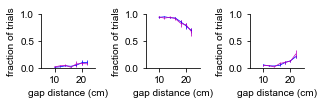

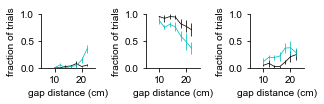

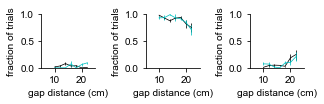

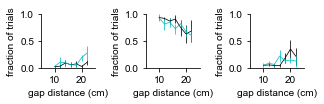

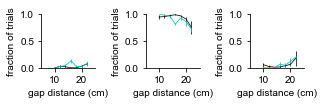

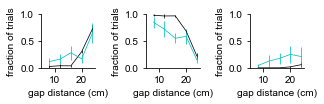

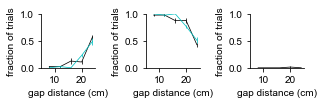

In [65]:
data_file = r'T:\jumping_revisions_analysis\df_decision_alldata_Side.h5'
df_side_revision = pd.read_hdf(data_file,key='df')


###### Baseline group analysis
df_cond = df_side_revision[(df_side_revision['condition']=='control')|(df_side_revision['condition']=='suture')]
df_cond.reset_index(inplace=True,drop=True)

condition = 'ocular'

fig, axs, array = am.plot_fraction_success(df_cond,condition,plot_params['bm_col'],'-',save_pdf,pp)
print('all subjects n=%d' % len(np.unique(df_cond['subject'])))
print('bi/mon fail/suc/abort anova p,F vals: ', am.anova_fraction_success(df_cond,array,condition))


### binocular opto
condition = 'laser_trial'
df_cond = df_side_revision[(df_side_revision['condition']=='controlopto')&(df_side_revision['expt_group']=='ChR2')]
fig, axs, array = am.plot_fraction_success(df_cond,condition,plot_params['laser_col'],'-',save_pdf,pp)
print('binoc vis/binoc V1 ChR2 n=%d' % len(np.unique(df_cond['subject'])))
print('bi/bi/ChR2 fail/suc/abort anova p,F vals: ', am.anova_fraction_success(df_cond,array,condition))

df_cond = df_side_revision[(df_side_revision['condition']=='controlopto')&(df_side_revision['expt_group']=='WT')]
fig, axs, array = am.plot_fraction_success(df_cond,condition,plot_params['laser_col'],'-',save_pdf,pp)
print('binoc vis/binoc V1 WT n=%d' % len(np.unique(df_cond['subject'])))
print('bi/bi/WT fail/suc/abort anova p,F vals: ', am.anova_fraction_success(df_cond,array,condition))


### monocular opto
condition = 'laser_trial'
df_cond = df_side_revision[(df_side_revision['condition']=='sutureopto')&(df_side_revision['expt_group']=='ChR2')]
fig, axs, array = am.plot_fraction_success(df_cond,condition,plot_params['laser_col'],'-',save_pdf,pp)
print('monoc vis/binoc V1 ChR2 n=%d' % len(np.unique(df_cond['subject'])))
print('mon/bi/ChR2 fail/suc/abort anova p,F vals: ', am.anova_fraction_success(df_cond,array,condition))

df_cond = df_side_revision[(df_side_revision['condition']=='sutureopto')&(df_side_revision['expt_group']=='WT')]
fig, axs, array = am.plot_fraction_success(df_cond,condition,plot_params['laser_col'],'-',save_pdf,pp)
print('monoc vis/binoc V1 WT n=%d' % len(np.unique(df_cond['subject'])))
print('mon/bi/WT fail/suc/abort anova p,F vals: ', am.anova_fraction_success(df_cond,array,condition))


### binocular opto in monocular V1
# condition = 'laser_trial'

# df_cond = df_side_og[(df_side_og['condition']=='background_opto_450nm_40Hz')|(df_side_og['condition']=='background_opto_450nm_continuous')|(df_side_og['condition']=='opto')|(df_side_og['condition']=='opto 450nm 40hz')]
# df_plot = df_cond[(df_cond['expt_group']=='ChR2')]
# fig, axs, array = am.plot_fraction_success(df_plot,condition,plot_params['laser_col'],'-',save_pdf,pp)
# print('binoc vis/monoc V1 ChR2 n=%d' % len(np.unique(df_plot['subject'])))
# print('bi/mon/ChR2 fail/suc/abort anova p,F vals: ', am.anova_fraction_success(df_plot,array,condition))

#there are no WT animals for binocular vision/monoc V1
# df_plot = df_cond[(df_cond['expt_group']=='WT')]
# fig, axs, array = am.plot_fraction_success(df_plot,condition,plot_params['laser_col'],'-',save_pdf,pp)
# print('binoc WT')
# print('bi/mon/WT fail/suc/abort anova p,F vals: ', am.anova_fraction_success(df_plot,array,condition))

### monocular opto in monocular V1
mvmnt_file = r'T:\jumping_revisions_analysis\df_corrected_pitch_og.h5'
df_side_og = pd.read_hdf(mvmnt_file,key='df')

condition = 'laser_trial'

df_cond = df_side_og[(df_side_og['condition']=='opto suture')|(df_side_og['condition']=='suture_background_opto_450nm_40Hz')|(df_side_og['condition']=='suture_background_opto_450nm_continuous')]
df_plot = df_cond[(df_cond['expt_group']=='ChR2')]
fig, axs, array = am.plot_fraction_success(df_plot,condition,plot_params['laser_col'],'-',save_pdf,pp)
print('monoc vis/monoc V1 ChR2 n=%d' % len(np.unique(df_plot['subject'])))
print('mon/mon/ChR2 fail/suc/abort anova p,F vals: ', am.anova_fraction_success(df_plot,array,condition))

df_plot = df_cond[(df_cond['expt_group']=='WT')]
fig, axs, array = am.plot_fraction_success(df_plot,condition,plot_params['laser_col'],'-',save_pdf,pp)
print('monoc vis/monoc V1 WT n=%d' % len(np.unique(df_plot['subject'])))
print('mon/mon/WT fail/suc/abort anova p,F vals: ', am.anova_fraction_success(df_plot,array,condition))

In [14]:
pp.close()

### movement frequency vs. trial duration, transition matrices

In [394]:
pwin = 0.25 #half the movement duration window desired
# metric = 'position'
metric = 'velocity'
mvmnt_file = r'T:\jumping_revisions_analysis\variable_platform_mvmnts_%sms_%s.h5' % (int(pwin*1000),metric)
df_pickle = mvmnt_file[:-3] + '_df.h5'
labels_pickle = mvmnt_file[:-3] + '_labels.h5'
df_all = pd.read_hdf(df_pickle,key='df')
labels_all = pd.read_hdf(labels_pickle,key='df')
print('%d hclusters %s' % (len(np.unique(labels_all['hclusters'])),metric))

group_label = {'PVCHA6LN':'WT','PVCHA6LT':'WT','PVCHA6RT':'ChR2','PVCHA7LN':'ChR2','PVCHA7LT':'WT','PVCHA7RN':'ChR2','PVCHA7RT':'ChR2','PVCHA7TT':'WT'}
expt_group = []
for index,row in labels_all.iterrows():
    expt_group.append(group_label[row['subject']])
labels_all['expt_group'] = expt_group


side = 'Side'
cluster_key = 'hclusters'
# cluster_key = 'kmeans'


hclusters_seq = []
for index,row in df_all.iterrows():
    h = labels_all[cluster_key].iloc[np.where((labels_all['subject']==row['subject'])&(labels_all['expdate']==row['expdate'])&(labels_all['trial']==row['trial']))[0]].to_numpy()
    hclusters_seq.append(h)
df_all['hclusters_seq'] = hclusters_seq

conds = ['control','suture']
n_hclust = len(np.unique(labels_all[cluster_key]))
tmat_hclust = np.zeros((n_hclust,n_hclust,len(conds)))

for c,cond in enumerate(conds):
    hclusters_seq = df_all['hclusters_seq'][df_all['condition']==cond]
    for seq in hclusters_seq:
        if len(seq>1):
            for i in np.arange(n_hclust):
                for j in np.arange(n_hclust):
                    cnt=0
                    i_inds = np.where(seq==i)[0]
                    if len(i_inds)>0:
                        i_inds += 1
                        if i_inds[-1]>=len(seq):
                            i_inds = i_inds[:-1]
                        if len(i_inds)>0:
                            for ind in i_inds:
                                if seq[ind]==j:
                                    cnt += 1
                            tmat_hclust[i,j,c] = tmat_hclust[i,j,c] + cnt
    tmat_hclust[:,:,c] /= np.sum(np.sum(tmat_hclust[:,:,c]))



10 hclusters velocity


In [404]:
save_pdf = True
pdf_file = r'G:\My Drive\Niell\Jumping paper\Manuscript\Resubmission\Figures\Supplemental\head_movement_panels.pdf'
pp = PdfPages(pdf_file)

base_df = df_all.copy()
base_df = base_df[(base_df['condition']=='control')|(base_df['condition']=='suture')]
base_df.reset_index(inplace=True,drop=True)
base_labels = labels_all.copy()
base_labels = base_labels[(base_labels['condition']=='control')|(base_labels['condition']=='suture')]
base_labels.reset_index(inplace=True,drop=True)


condition = 'ocular'
fig, ax = am.plot_movement_clusters(base_df,base_labels,side,cluster_key,condition,plot_params,save_pdf,pp)

vmax=0.05
fig , axs = plt.subplots(1,2,figsize=(4,2))
axs = axs.ravel()
for c,cond in enumerate(conds):
    ax = axs[c]
    im = ax.imshow(tmat_hclust[:,:,c],vmin=0,vmax=0.05,cmap='jet')
    ax.set_title(cond)
    ax.set_xlabel('mvmnt i')
    ax.set_ylabel('mvmnt j')
    plt.colorbar(im, ax=ax, ticks = np.arange(0,vmax+vmax/5,vmax/5))
# fig.suptitle('movement transition matrices')
fig.tight_layout()
pp.savefig(fig)
plt.close(fig)

fig , axs = plt.subplots(1,1,figsize=(2,2))
axs = am.plot_cluster_freq(axs,base_df,base_labels,cluster_key,condition,0,4,plot_params['bm_col'],save_pdf,pp)
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

fig, ax = am.plot_movement_timing(base_labels,side,cluster_key,condition,0.025,-5,0.5,pwin,plot_params,save_pdf,pp)


trial_length = []
for index,row in df_all.iterrows():
    trial_length.append((row['Top_Jump']-row['Top_Start'])/100)
df_all['trial_length'] = trial_length


### baseline behavior
df_cond = df_all[(df_all['condition']=='control')|(df_all['condition']=='suture')]#|(df_all['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
labels_cond = labels_all[(labels_all['condition']=='control')|(labels_all['condition']=='suture')]#|(labels_all['success']!=2)]
labels_cond.reset_index(inplace=True,drop=True)

condition = 'ocular'
fig, axs = plt.subplots(1,1,figsize=(2,2))
axs = am.plot_movs_per_sec(axs,df_cond,labels_cond,condition,cluster_key,0,1,plot_params['bm_col'],save_pdf,pp,suptitle='')
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

fig, axs = plt.subplots(1,3,figsize=(2*3,2))
axs = am.plot_variable_vs_distance_manipulation(axs,df_cond,'trial_length','success',condition,8,24,0,20,plot_params['bm_col'],save_pdf,pp,suptitle='')

fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

### binocular opto
df_cond = df_all[(df_all['condition']=='controlopto')]
df_cond.reset_index(inplace=True,drop=True)
labels_cond = labels_all[(labels_all['condition']=='controlopto')]
labels_cond.reset_index(inplace=True,drop=True)

condition = 'expt_group'

fig, axs = plt.subplots(1,2,figsize=(4,2))
axs = axs.ravel()
for c,cond in enumerate(np.unique(df_cond[condition])):
    ax = axs[c]
    df_plot = df_cond[df_cond[condition]==cond]
    labels_plot = labels_cond[labels_cond[condition]==cond]
    ax = am.plot_cluster_freq(ax,df_plot,labels_plot,cluster_key,'laser_trial',0,6,plot_params['laser_col'],save_pdf,pp)
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

fig, axs = plt.subplots(1,2,figsize=(4,2))
axs = axs.ravel()
for c,cond in enumerate(np.unique(df_cond[condition])):
    ax = axs[c]
    df_plot = df_cond[df_cond[condition]==cond]
    labels_plot = labels_cond[labels_cond[condition]==cond]
    ax = am.plot_movs_per_sec(ax,df_plot,labels_plot,'laser_trial',cluster_key,0,1,plot_params['laser_col'],save_pdf,pp,suptitle='')
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)
    
fig, axs = plt.subplots(1,2,figsize=(2*2,2))
axs = am.plot_variable_vs_distance_manipulation(axs,df_cond,'trial_length',condition,'laser_trial',8,24,0,20,plot_params['laser_col'],save_pdf,pp,suptitle='')

fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)


### monocular opto
df_cond = df_all[(df_all['condition']=='sutureopto')]
df_cond.reset_index(inplace=True,drop=True)
labels_cond = labels_all[(labels_all['condition']=='sutureopto')]
labels_cond.reset_index(inplace=True,drop=True)

condition = 'expt_group'

fig, axs = plt.subplots(1,2,figsize=(4,2))
axs = axs.ravel()
for c,cond in enumerate(np.unique(df_cond[condition])):
    ax = axs[c]
    df_plot = df_cond[df_cond[condition]==cond]
    labels_plot = labels_cond[labels_cond[condition]==cond]
    ax = am.plot_cluster_freq(ax,df_plot,labels_plot,cluster_key,'laser_trial',0,6,plot_params['laser_col'],save_pdf,pp)
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

fig, axs = plt.subplots(1,2,figsize=(4,2))
axs = axs.ravel()
for c,cond in enumerate(np.unique(df_cond[condition])):
    ax = axs[c]
    df_plot = df_cond[df_cond[condition]==cond]
    labels_plot = labels_cond[labels_cond[condition]==cond]
    ax = am.plot_movs_per_sec(ax,df_plot,labels_plot,'laser_trial',cluster_key,0,1,plot_params['laser_col'],save_pdf,pp,suptitle='')
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)
    
fig, axs = plt.subplots(1,2,figsize=(2*2,2))
axs = am.plot_variable_vs_distance_manipulation(axs,df_cond,'trial_length',condition,'laser_trial',8,24,0,20,plot_params['laser_col'],save_pdf,pp,suptitle='')

fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

pp.close()

print('finished plotting movement data for %s %d' % (cluster_key,len(np.unique(labels_all[cluster_key]))))

finished plotting movement data for hclusters 10


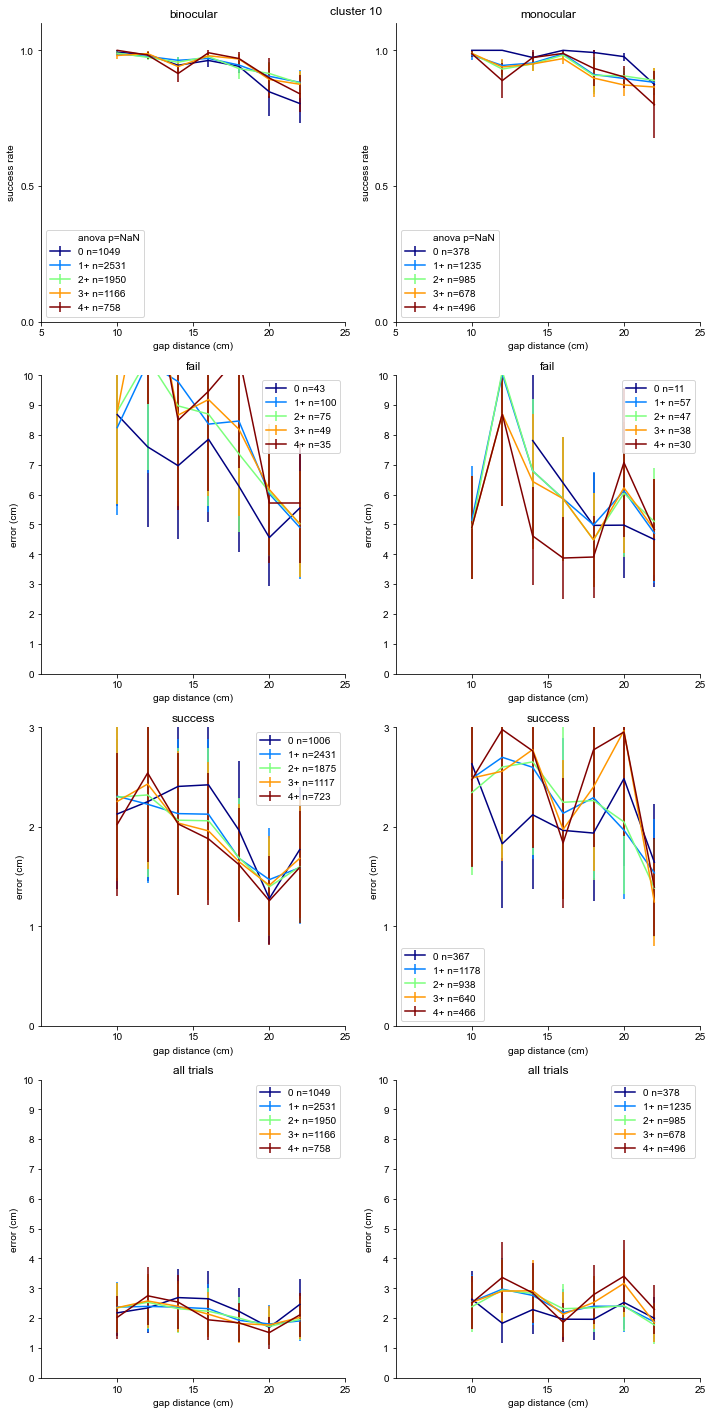

In [30]:
pwin = 0.25 #half the movement duration window desired
# metric = 'position'
metric = 'velocity'
mvmnt_file = r'T:\jumping_revisions_analysis\variable_platform_mvmnts_%sms_%s.h5' % (int(pwin*1000),metric)
df_pickle = mvmnt_file[:-3] + '_df.h5'
labels_pickle = mvmnt_file[:-3] + '_labels.h5'
df_all = pd.read_hdf(df_pickle,key='df')
labels_all = pd.read_hdf(labels_pickle,key='df')

base_df = df_all.copy()
base_df = base_df[(base_df['condition']=='control')|(base_df['condition']=='suture')]
base_df.reset_index(inplace=True,drop=True)
base_labels = labels_all.copy()
base_labels = base_labels[(base_labels['condition']=='control')|(base_labels['condition']=='suture')]
base_labels.reset_index(inplace=True,drop=True)

cluster_num = 8
base_df = am.label_bob_frequency(base_df,base_labels,'hclusters',cluster_num)
fig, axs = am.plot_performance_bob_freq(base_df,'ocular','bob_freq',4,False,pp,'cluster 10')

### number of sessions, avg trials per animal per condition

In [112]:
### revision data
data_file = r'T:\jumping_revisions_analysis\df_jumpDLCpoints_corrected.h5'
df = pd.read_hdf(data_file,key='df')

### og data
data_file = r'T:\df_jumpDLCpts.h5'
df_og = pd.read_hdf(data_file,key='df')

### eyecam data
h5file = r'T:\eyecam_data.h5'
df_eyecam = pd.read_hdf(h5file)

In [143]:
def calculate_session_trial_numbers(df_cond):
    anis = np.unique(df_cond['subject'])
    n_anis = len(anis)
    sess = np.zeros(n_anis)
    trials = np.zeros(n_anis)
    for a,ani in enumerate(anis):
        df_temp = df_cond[df_cond['subject']==ani]
        sess[a] = len(np.unique(df_temp['expdate']))
        trials[a] = df_temp.shape[0]/sess[a]
    n_sess = np.mean(sess)
    n_sess_sem = np.std(sess)/np.sqrt(n_anis)
    n_trials = np.mean(trials)
    n_trials_sem = np.std(trials)/np.sqrt(n_anis)

    return n_anis, n_sess, n_sess_sem, n_trials, n_trials_sem


In [144]:
cond = 'control'
df_cond = df[df['condition']==cond]
numAni, n_sess, n_sess_sem, n_trials, n_trials_sem = calculate_session_trial_numbers(df_cond)
print('condition: %s, #anis=%0.1f, #sessions=%0.1f +/- %0.1f, #trials=%0.1f +/- %0.1f' % (cond,numAni,n_sess,n_sess_sem,n_trials,n_trials_sem))

cond = 'suture'
df_cond = df[df['condition']==cond]
numAni, n_sess, n_sess_sem, n_trials, n_trials_sem = calculate_session_trial_numbers(df_cond)
print('condition: %s, #anis=%0.1f, #sessions=%0.1f +/- %0.1f, #trials=%0.1f +/- %0.1f' % (cond,numAni,n_sess,n_sess_sem,n_trials,n_trials_sem))

cond = 'controlopto'
df_cond = df[df['condition']==cond]
numAni, n_sess, n_sess_sem, n_trials, n_trials_sem = calculate_session_trial_numbers(df_cond)
print('condition: %s, #anis=%0.1f, #sessions=%0.1f +/- %0.1f, #trials=%0.1f +/- %0.1f' % (cond,numAni,n_sess,n_sess_sem,n_trials,n_trials_sem))

cond = 'sutureopto'
df_cond = df[df['condition']==cond]
numAni, n_sess, n_sess_sem, n_trials, n_trials_sem = calculate_session_trial_numbers(df_cond)
print('condition: %s, #anis=%0.1f, #sessions=%0.1f +/- %0.1f, #trials=%0.1f +/- %0.1f' % (cond,numAni,n_sess,n_sess_sem,n_trials,n_trials_sem))

condition: control, #anis=8.0, #sessions=11.4 +/- 0.6, #trials=42.1 +/- 2.3
condition: suture, #anis=8.0, #sessions=5.6 +/- 0.2, #trials=39.0 +/- 3.4
condition: controlopto, #anis=8.0, #sessions=6.8 +/- 0.2, #trials=34.3 +/- 2.6
condition: sutureopto, #anis=8.0, #sessions=4.8 +/- 0.2, #trials=33.5 +/- 1.8


In [145]:
cond = 'opto suture'
df_cond = df_og[df_og['condition']==cond]
numAni, n_sess, n_sess_sem, n_trials, n_trials_sem = calculate_session_trial_numbers(df_cond)
print('condition: %s, #anis=%0.1f, #sessions=%0.1f +/- %0.1f, #trials=%0.1f +/- %0.1f' % (cond,numAni,n_sess,n_sess_sem,n_trials,n_trials_sem))

condition: opto suture, #anis=8.0, #sessions=3.6 +/- 0.2, #trials=27.2 +/- 1.7


In [146]:
cond = 'eyecams'
df_cond = df_eyecam.copy()
numAni, n_sess, n_sess_sem, n_trials, n_trials_sem = calculate_session_trial_numbers(df_cond)
print('condition: %s, #anis=%0.1f, #sessions=%0.1f +/- %0.1f, #trials=%0.1f +/- %0.1f' % (cond,numAni,n_sess,n_sess_sem,n_trials,n_trials_sem))

condition: eyecams, #anis=8.0, #sessions=2.8 +/- 0.3, #trials=13.9 +/- 0.7
